In [17]:
import pandas as pd
import numpy as np
from skimpy import clean_columns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns

from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import chi2
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from matplotlib.patches import Patch


plt.rcParams['font.sans-serif'] = ['Avenir']
plt.style.use('dark_background')
plt.rcParams.update({'font.size': 16})


# Read Data

In [3]:
# Read literature review data.

lit_review_data = pd.read_csv("lit_review_data.csv")
lit_review_data = clean_columns(lit_review_data)
lit_review_data


,title,author,year,country,continent,climate,comparison,response,response_category,response_type,...,local_effect,landscape,radius,landscape_gradient,minimum_complexity,maximum_complexity,landscape_effect,interaction_details,interaction_effect,description
0,A macro-scale perspective on within-farm manag...,Amano et al.,2011,Japan,Asia,NaN,Conventional,Spider abundance,Natural enemy,Biodiversity,...,Negative,The proportion of forest area surrounding the ...,250.0,"<20% forest, >20% forest",NaN,NaN,Positive,NS,NS,A multilevel modelling approach revealed that ...
1,A multitaxa assessment of the effectiveness of...,Boetzel et al.,2021,Germany,Europe,NaN,Conventional,Cicada species richness,Arthropod,Biodiversity,...,NS,The amount of seminatural habitat (forest edge...,1000.0,3.6-25% semi-natural habitat,3.6,25.0,NS,NS,NS,All other taxonomic groups showed no significa...
2,A multitaxa assessment of the effectiveness of...,Boetzel et al.,2021,Germany,Europe,NaN,Conventional,Orthopteran species richness,Arthropod,Biodiversity,...,NS,The amount of seminatural habitat (forest edge...,1000.0,3.6-25% semi-natural habitat,3.6,25.0,NS,NS,NS,All other taxonomic groups showed no significa...
3,A multitaxa assessment of the effectiveness of...,Boetzel et al.,2021,Germany,Europe,NaN,Conventional,Bee species richness,Pollinator,Biodiversity,...,NS,The amount of seminatural habitat (forest edge...,1000.0,3.6-25% semi-natural habitat,3.6,25.0,Positive,NS,NS,An increasing proportion of seminatural habita...
4,A multitaxa assessment of the effectiveness of...,Boetzel et al.,2021,Germany,Europe,NaN,Conventional,Butterfly species richness,Pollinator,Biodiversity,...,NS,The amount of seminatural habitat (forest edge...,1000.0,3.6-25% semi-natural habitat,3.6,25.0,NS,NS,NS,All other taxonomic groups showed no significa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,Wild bee pollinators provide the majority of c...,Winfree et al.,2007,United States,North America,NaN,Conventional,Abundance (wood-nesting bees),Pollinator,Biodiversity,...,NS,We analysed landscape cover as the proportion ...,2000.0,3-64% woodland,3.0,64.0,NS,NS,NS,The abundance of wood-nesting bees was associa...
577,Wild bee pollinators provide the majority of c...,Winfree et al.,2007,United States,North America,NaN,Conventional,Wild bee visitation,Pollinator,Ecosystem services,...,NS,We analysed landscape cover as the proportion ...,2000.0,3-64% woodland,3.0,64.0,NS,NS,NS,"Similarly, no individual variables were strong..."
578,Wild bee pollinators provide the majority of c...,Winfree et al.,2007,United States,North America,NaN,Conventional,Abundance (eusocial bees),Pollinator,Biodiversity,...,NS,We analysed landscape cover as the proportion ...,2000.0,3-64% woodland,3.0,64.0,NS,NS,NS,"Similarly, no individual variables were strong..."
579,Wild bee pollinators provide the majority of c...,Winfree et al.,2007,United States,North America,NaN,Conventional,Abundance (solitary bees),Pollinator,Biodiversity,...,Positive,We analysed landscape cover as the proportion ...,2000.0,3-64% woodland,3.0,64.0,NS,NS,NS,The abundance of solitary bees showed little a...


In [4]:
# Convert column data types.

lit_review_data[
    [
        "title",
        "author",
        "country",
        "continent",
        "comparison",
        "response",
        "response_category",
        "local_factor",
        "local_strategy",
        "local_effect",
        "landscape",
        "landscape_effect",
        "interaction_effect",
        "response_type",
    ]
] = lit_review_data.loc[
    :,
    [
        "title",
        "author",
        "country",
        "continent",
        "comparison",
        "response",
        "response_category",
        "local_factor",
        "local_strategy",
        "local_effect",
        "landscape",
        "landscape_effect",
        "interaction_effect",
        "response_type",
    ],
].astype(
    "category"
)


In [5]:
lit_review_data['radius'].mean()

920.5436720142602

In [6]:
lit_review_data['radius'].sem()

22.143201265841817

In [7]:
lit_review_data.groupby('radius').count()[['title']]

,title
radius,
100.0,3
175.0,2
200.0,2
250.0,17
300.0,6
400.0,9
500.0,161
750.0,18
775.0,10


In [8]:
lit_review_data.groupby('radius').count()[['title']].sum()

title    561
dtype: int64

In [9]:
# Read landscape category data.

landscape_cat = pd.read_csv("lit_review_landscape_percents.csv")
landscape_cat = clean_columns(landscape_cat)
landscape_cat


,title,author_s,year,simple_start,simple_end,int_start,int_end,complex_start,complex_end,metric,detail
0,Benefits of wildflower areas as overwintering ...,Hoffmann et al.,2021,0.0,2.00,3.00,4.00,5.00,7.00,Semi-natural habitats,permanent semi-natural habitats and transient ...
1,Testing scale-dependent effects of seminatural...,Dainese et al.,2015,1.0,3.00,4.00,19.00,20.00,30.00,Semi-natural habitat,NaN
2,The benefits of hedgerows for pollinators and ...,Garratt et al.,2017,0.0,4.71,4.72,9.88,9.89,41.97,Semi-natural habitat,NaN
3,Multi-scale effects of landscape complexity an...,Rusch et al.,2011,0.0,5.00,6.00,NaN,NaN,58.00,Semi-natural habitats,NaN
4,Pest control potential of adjacent agri-enviro...,Boetzel et al.,2020,3.6,5.00,6.00,19.00,20.00,31.60,Semi-natural habitat,NaN
...,...,...,...,...,...,...,...,...,...,...,...
121,Organic farming affects the biological control...,Birkhofer et al.,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,Organic farming supports lower pest infestatio...,Torok et al.,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,Scale-dependent environmental filtering of gro...,Ruzickova et al.,2020,NaN,20.00,NaN,NaN,21.00,NaN,Semi-natural habitat,NaN
124,"Sweep netting samples, but not sticky trap sam...",Bakker et al.,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
landscape_geog = landscape_cat.merge(lit_review_data, on='title')
landscape_geog = landscape_geog[['simple_start', 'simple_end', 'int_start', 'int_end', 'complex_start', 'complex_end', 'continent']].dropna()
landscape_geog

,simple_start,simple_end,int_start,int_end,complex_start,complex_end,continent
0,0.0,2.0,3.0,4.0,5.0,7.0,Europe
1,0.0,2.0,3.0,4.0,5.0,7.0,Europe
2,0.0,2.0,3.0,4.0,5.0,7.0,Europe
3,0.0,2.0,3.0,4.0,5.0,7.0,Europe
4,0.0,2.0,3.0,4.0,5.0,7.0,Europe
...,...,...,...,...,...,...,...
153,45.0,50.0,51.0,69.0,70.0,76.0,Africa
154,52.0,74.0,75.0,84.0,85.0,98.0,Australia
155,52.0,74.0,75.0,84.0,85.0,98.0,Australia
156,52.0,74.0,75.0,84.0,85.0,98.0,Australia


In [11]:
landscape_geog['Simple'] = landscape_geog[['simple_start', 'simple_end']].mean(axis=1)
landscape_geog['Intermediate'] = landscape_geog[['int_start', 'int_end']].mean(axis=1)
landscape_geog['Complex'] = landscape_geog[['complex_start', 'complex_end']].mean(axis=1)

landscape_geog


,simple_start,simple_end,int_start,int_end,complex_start,complex_end,continent,Simple,Intermediate,Complex
0,0.0,2.0,3.0,4.0,5.0,7.0,Europe,1.0,3.5,6.0
1,0.0,2.0,3.0,4.0,5.0,7.0,Europe,1.0,3.5,6.0
2,0.0,2.0,3.0,4.0,5.0,7.0,Europe,1.0,3.5,6.0
3,0.0,2.0,3.0,4.0,5.0,7.0,Europe,1.0,3.5,6.0
4,0.0,2.0,3.0,4.0,5.0,7.0,Europe,1.0,3.5,6.0
...,...,...,...,...,...,...,...,...,...,...
153,45.0,50.0,51.0,69.0,70.0,76.0,Africa,47.5,60.0,73.0
154,52.0,74.0,75.0,84.0,85.0,98.0,Australia,63.0,79.5,91.5
155,52.0,74.0,75.0,84.0,85.0,98.0,Australia,63.0,79.5,91.5
156,52.0,74.0,75.0,84.0,85.0,98.0,Australia,63.0,79.5,91.5


In [25]:
landscape_europe = landscape_geog.loc[landscape_geog['continent'] == 'Europe'][['Simple', 'Intermediate', 'Complex']]
landscape_europe = pd.melt(landscape_europe)

landscape_europe['value'] = pd.to_numeric(landscape_europe['value'])

landscape_europe

,variable,value
0,Simple,1.0
1,Simple,1.0
2,Simple,1.0
3,Simple,1.0
4,Simple,1.0
...,...,...
253,Complex,67.5
254,Complex,67.5
255,Complex,58.5
256,Complex,58.5


/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

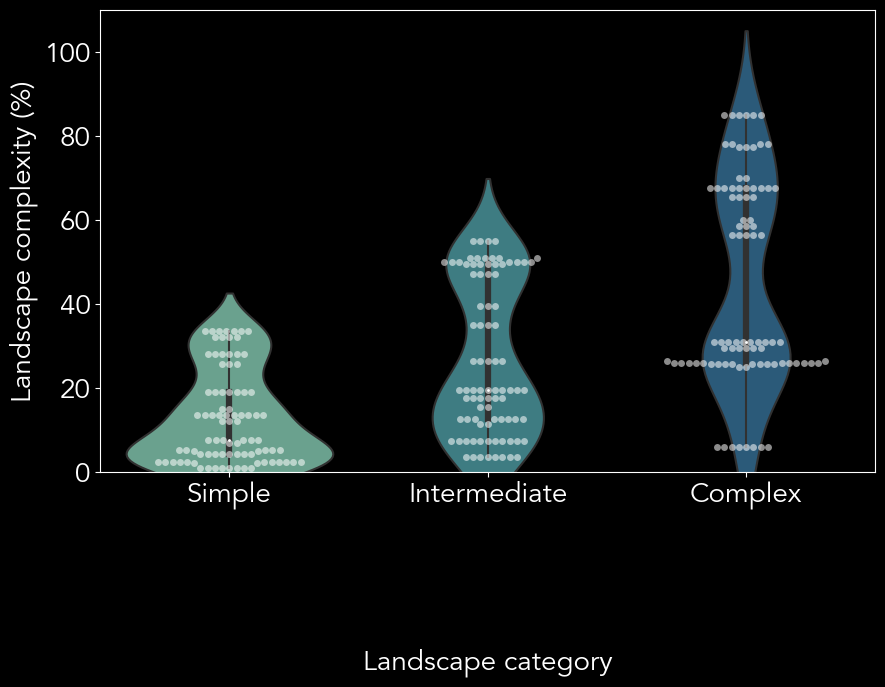

In [49]:
plt.rcParams['font.sans-serif'] = ['Avenir']
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,6))

landscape_europe = landscape_europe.dropna()

sns.violinplot(x="variable", y="value", data=landscape_europe,inner='box', capsize=.1, errorbar=('ci', 95), palette="crest")
sns.swarmplot(x="variable", y="value", data=landscape_europe, color="1", alpha=.55)

plt.xlabel('Landscape category', labelpad=100)
plt.ylabel('Landscape complexity (%)')
plt.ylim(0,110)

plt.show()


In [60]:
group1 = landscape_europe.loc[landscape_europe['variable'] == 'Simple']['value'].dropna()
group2 = landscape_europe.loc[landscape_europe['variable'] == 'Intermediate']['value'].dropna()
group3 = landscape_europe.loc[landscape_europe['variable'] == 'Complex']['value'].dropna()

f_oneway(group1, group2, group3)

F_onewayResult(statistic=62.29882286929887, pvalue=9.335239093246308e-23)

In [21]:
landscape_europe.groupby('variable').agg(['mean', 'sem'])

value          
                   mean       sem
variable                         
Complex       44.625814  2.634947
Intermediate  26.898837  1.952823
Simple        12.889884  1.193343

In [22]:
landscape_us = landscape_geog.loc[landscape_geog['continent'] == 'North America'][['Simple', 'Intermediate', 'Complex']]
landscape_us = pd.melt(landscape_us)

landscape_us['value'] = pd.to_numeric(landscape_us['value'])

landscape_us

,variable,value
0,Simple,4.0
1,Simple,4.0
2,Simple,4.0
3,Simple,4.0
4,Simple,4.0
...,...,...
121,Complex,71.0
122,Complex,71.0
123,Complex,87.5
124,Complex,87.5


/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

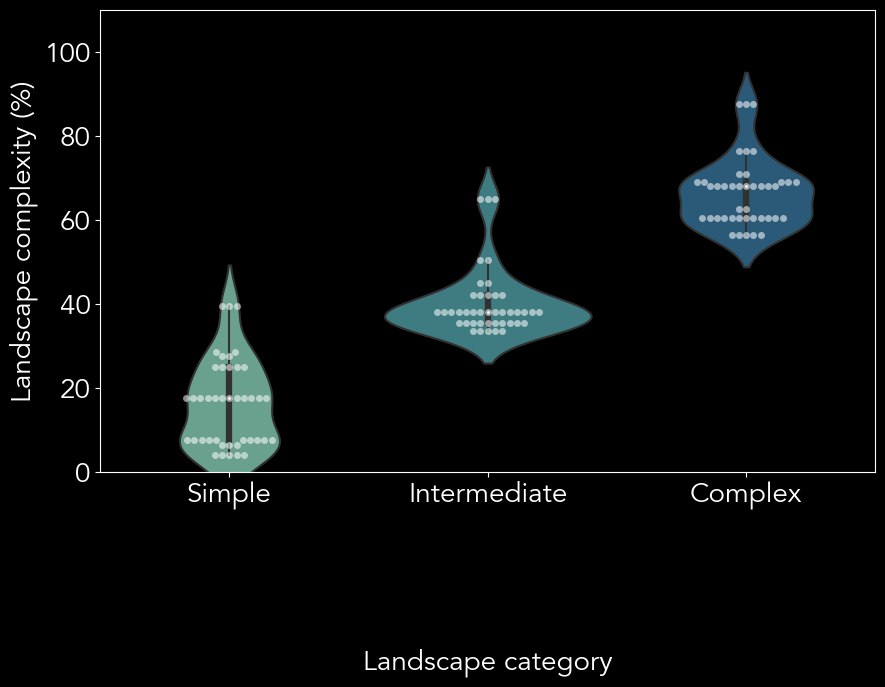

In [59]:
plt.rcParams['font.sans-serif'] = ['Avenir']
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,6))

landscape_us = landscape_us.dropna()

sns.violinplot(x="variable", y="value", data=landscape_us, capsize=.1, errorbar=('ci', 95), palette="crest")
sns.swarmplot(x="variable", y="value", data=landscape_us, color="1", alpha=.55)

plt.xlabel('Landscape category', labelpad=100)
plt.ylabel('Landscape complexity (%)')
plt.ylim(0,110)

plt.show()


In [61]:
group1 = landscape_us.loc[landscape_us['variable'] == 'Simple']['value'].dropna()
group2 = landscape_us.loc[landscape_us['variable'] == 'Intermediate']['value'].dropna()
group3 = landscape_us.loc[landscape_us['variable'] == 'Complex']['value'].dropna()

f_oneway(group1, group2, group3)

F_onewayResult(statistic=337.1950674352505, pvalue=1.1923577091149008e-50)

In [28]:
landscape_us.groupby('variable').agg(['mean', 'sem'])

value          
                   mean       sem
variable                         
Complex       66.488095  1.247819
Intermediate  40.202381  1.237605
Simple        16.190476  1.594393

In [29]:
simple_start = np.average(landscape_cat['simple_start'].dropna())
simple_start

10.21517857142857

In [30]:
simple_start_se = np.std(landscape_cat['simple_start'].dropna())
simple_start_se

14.60375850485457

In [31]:
simple_end = np.average(landscape_cat['simple_end'].dropna())
simple_end

21.874615384615385

In [32]:
simple_end_se = np.std(landscape_cat['simple_end'].dropna())
simple_end_se

16.255343081529375

In [33]:
int_start = np.average(landscape_cat['int_start'].dropna())
int_start

22.699142857142856

In [34]:
int_start_se = np.std(landscape_cat['int_start'].dropna())
int_start_se

17.3873458701483

In [35]:
int_end = np.average(landscape_cat['int_end'].dropna())
int_end

45.29625

In [36]:
int_end_se = np.std(landscape_cat['int_end'].dropna())
int_end_se

21.26733553921365

In [37]:
complex_start = np.average(landscape_cat['complex_start'].dropna())
complex_start

43.39702702702703

In [38]:
complex_start_se = np.std(landscape_cat['complex_start'].dropna())
complex_start_se

21.196225934447256

In [39]:
complex_end = np.average(landscape_cat['complex_end'].dropna())
complex_end

60.67327272727273

In [40]:
complex_end_se = np.std(landscape_cat['complex_end'].dropna())
complex_end_se

24.33871189200413

In [41]:
cat_df = landscape_cat[['simple_start', 'simple_end', 'int_start', 'int_end', 'complex_start', 'complex_end']]
cat_df



,simple_start,simple_end,int_start,int_end,complex_start,complex_end
0,0.0,2.00,3.00,4.00,5.00,7.00
1,1.0,3.00,4.00,19.00,20.00,30.00
2,0.0,4.71,4.72,9.88,9.89,41.97
3,0.0,5.00,6.00,NaN,NaN,58.00
4,3.6,5.00,6.00,19.00,20.00,31.60
...,...,...,...,...,...,...
121,NaN,NaN,NaN,NaN,NaN,NaN
122,NaN,NaN,NaN,NaN,NaN,NaN
123,NaN,20.00,NaN,NaN,21.00,NaN
124,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
cat_df['Simple'] = cat_df[['simple_start', 'simple_end']].mean(axis=1)
cat_df['Intermediate'] = cat_df[['int_start', 'int_end']].mean(axis=1)
cat_df['Complex'] = cat_df[['complex_start', 'complex_end']].mean(axis=1)

cat_df


/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_14288/1748520288.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['Simple'] = cat_df[['simple_start', 'simple_end']].mean(axis=1)
/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_14288/1748520288.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['Intermediate'] = cat_df[['int_start', 'int_end']].mean(axis=1)
/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_14288/1748520288.py:3: SettingWithCopyWarning: 
A value

,simple_start,simple_end,int_start,int_end,complex_start,complex_end,Simple,Intermediate,Complex
0,0.0,2.00,3.00,4.00,5.00,7.00,1.000,3.5,6.00
1,1.0,3.00,4.00,19.00,20.00,30.00,2.000,11.5,25.00
2,0.0,4.71,4.72,9.88,9.89,41.97,2.355,7.3,25.93
3,0.0,5.00,6.00,NaN,NaN,58.00,2.500,6.0,58.00
4,3.6,5.00,6.00,19.00,20.00,31.60,4.300,12.5,25.80
...,...,...,...,...,...,...,...,...,...
121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,NaN,20.00,NaN,NaN,21.00,NaN,20.000,NaN,21.00
124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
cat_df = cat_df[['Simple', 'Intermediate', 'Complex']]
cat_df = pd.melt(cat_df)

cat_df

,variable,value
0,Simple,1.000
1,Simple,2.000
2,Simple,2.355
3,Simple,2.500
4,Simple,4.300
...,...,...
373,Complex,NaN
374,Complex,NaN
375,Complex,21.000
376,Complex,NaN


/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

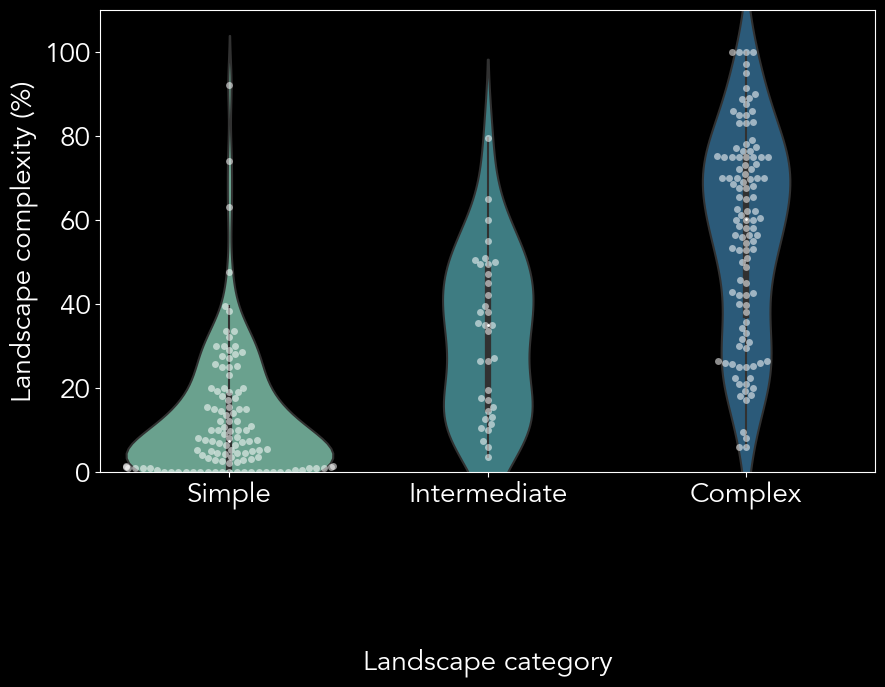

In [50]:
plt.rcParams['font.sans-serif'] = ['Avenir']
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,6))

cat_df = cat_df.dropna()

sns.violinplot(x="variable", y="value", data=cat_df, capsize=.1, errorbar=('ci', 95), palette="crest")
sns.swarmplot(x="variable", y="value", data=cat_df, color="1", alpha=.55)

plt.xlabel('Landscape category', labelpad=100)
plt.ylabel('Landscape complexity (%)')
plt.ylim(0,110)

plt.show()


In [51]:
group1 = cat_df.loc[cat_df['variable'] == 'Simple']['value'].dropna()
group2 = cat_df.loc[cat_df['variable'] == 'Intermediate']['value'].dropna()
group3 = cat_df.loc[cat_df['variable'] == 'Complex']['value'].dropna()

f_oneway(group1, group2, group3)

F_onewayResult(statistic=138.73483981233232, pvalue=1.3749645290350455e-41)

In [52]:
cat_df = cat_df.dropna()

In [53]:
print(stats.tukey_hsd(group1, group2, group3))

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)    -20.219     0.000   -29.422   -11.017
 (0 - 2)    -44.793     0.000   -51.136   -38.450
 (1 - 0)     20.219     0.000    11.017    29.422
 (1 - 2)    -24.574     0.000   -33.786   -15.362
 (2 - 0)     44.793     0.000    38.450    51.136
 (2 - 1)     24.574     0.000    15.362    33.786



In [54]:
stats.tukey_hsd(group1, group2, group3).pvalue

array([[1.00000000e+00, 1.34401706e-06, 0.00000000e+00],
       [1.34401706e-06, 1.00000000e+00, 4.10450030e-09],
       [0.00000000e+00, 4.10450030e-09, 1.00000000e+00]])

In [55]:
cat_df

,variable,value
0,Simple,1.000
1,Simple,2.000
2,Simple,2.355
3,Simple,2.500
4,Simple,4.300
...,...,...
360,Complex,60.000
361,Complex,97.000
362,Complex,62.000
363,Complex,42.500


In [56]:
cat_df.groupby('variable').agg(['mean', 'sem'])

value          
                   mean       sem
variable                         
Complex       57.046964  2.302824
Intermediate  32.472857  3.228720
Simple        12.253717  1.442172

In [57]:
cat_df.groupby('variable').agg(['mean', 'std'])

value           
                   mean        std
variable                          
Complex       57.046964  24.370798
Intermediate  32.472857  19.101368
Simple        12.253717  15.330501

In [58]:
lit_review_data.local_strategy.value_counts(ascending=True)


local_strategy
Structure     58
Diversity     73
Floral       139
Intensity    311
Name: count, dtype: int64

In [141]:
lit_review_data.response_category.value_counts(ascending=True)


response_category
Arthropod         32
Crop              69
Pest              74
Pollinator       120
Natural enemy    286
Name: count, dtype: int64

In [142]:
lit_review_data.response_type.value_counts(ascending=True)


response_type
Ecosystem services    227
Biodiversity          354
Name: count, dtype: int64

/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_44984/986764132.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["local_strategy"])[["local_effect"]]


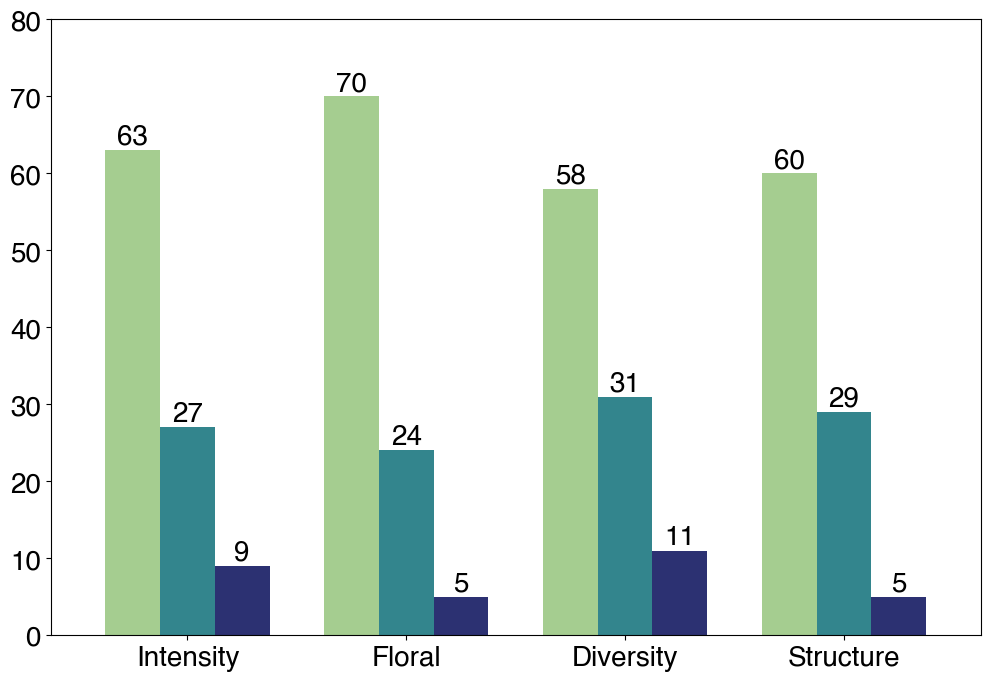

In [143]:
# Plotting local effects of local practices.

plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 20})

ax1 = (
    lit_review_data
    .groupby(["local_strategy"])[["local_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(0)
    .unstack()[["NS", "Positive", "Negative"]]
    .loc[['Intensity', 'Floral', 'Diversity', 'Structure']]
    .plot(
        kind="bar",
        width=0.75,
        colormap="crest",
        #title="Effects of Local Management Practices",
        #ylabel="Percent of Observations",
        #xlabel="Local Management Practice Category",
        rot=0,
        figsize=(12, 8)
    )
)

for container in ax1.containers:
    ax1.bar_label(container, fontsize=20, fmt="%d")

#ax1.legend(title="Effect")

plt.xlabel(None)
plt.ylim(0,80)
ax1.get_legend().remove()


In [144]:
strategy_local_effect = (
    lit_review_data.groupby(["local_strategy"])[["local_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .unstack()[["NS", "Positive", "Negative"]]
    .T
)

strategy_local_effect


/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_44984/1675277689.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lit_review_data.groupby(["local_strategy"])[["local_effect"]]


local_strategy,Diversity,Floral,Intensity,Structure
local_effect,,,,
NS,58.3,69.8,63.3,60.3
Positive,30.6,24.5,27.3,29.3
Negative,11.1,5.0,9.3,5.2


In [145]:
stats.chisquare(strategy_local_effect)


Power_divergenceResult(statistic=array([33.7538    , 66.78126888, 45.40540541, 48.28924051]), pvalue=array([4.68225927e-08, 3.15233029e-15, 1.38147011e-10, 3.26681587e-11]))

In [146]:
stats.chisquare(strategy_local_effect.T)


Power_divergenceResult(statistic=array([1.20282082, 0.75801253, 3.61437908]), pvalue=array([0.75232784, 0.85948122, 0.30622771]))

In [147]:
stats.chi2_contingency(strategy_local_effect)


Chi2ContingencyResult(statistic=5.365451934049767, pvalue=0.49786544028344015, dof=6, expected_freq=array([[63.88324873, 63.43606599, 63.81936548, 60.5613198 ],
       [28.35025381, 28.15180203, 28.32190355, 26.87604061],
       [ 7.76649746,  7.71213198,  7.75873096,  7.36263959]]))

/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_44984/3098066948.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lit_review_data.groupby(["local_strategy"])[["landscape_effect"]]


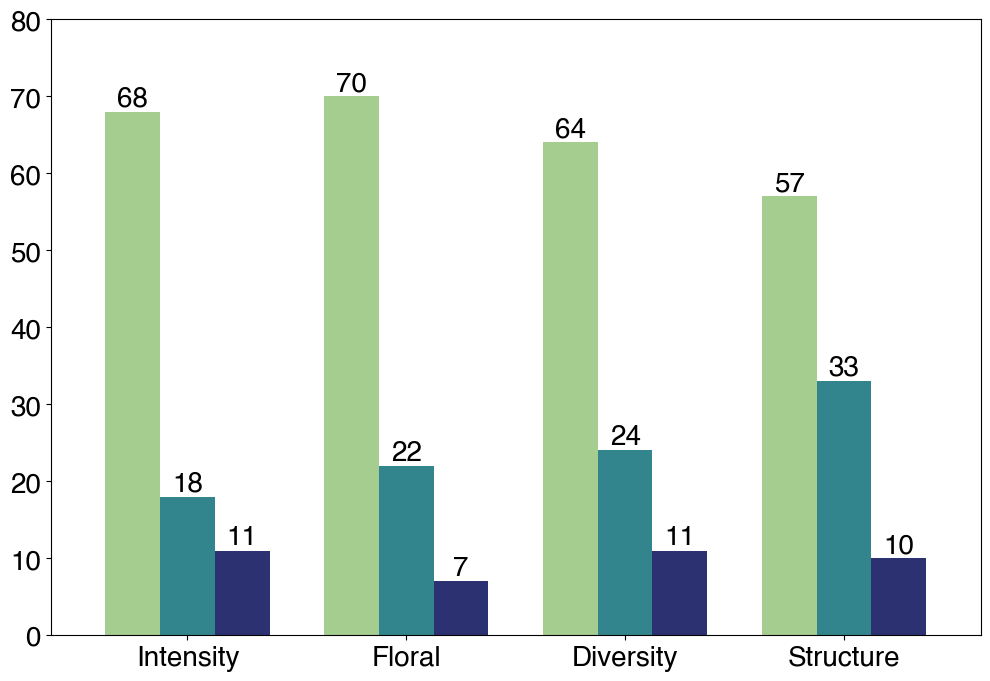

In [148]:
# Plotting effects of local practices across landscape gradients.
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 20})

ax2 = (
    lit_review_data.groupby(["local_strategy"])[["landscape_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(0)
    .unstack()[["NS", "Positive", "Negative"]]
    .loc[['Intensity', 'Floral', 'Diversity', 'Structure']]
    .plot(
        kind="bar",
        width=0.75,
        colormap="crest",
        #title="Effects of Landscape Complexity, Subset by Local Management",
        #ylabel="Percent of Observations",
        #xlabel="Local Management Practice Category",
        rot=0,
        figsize=(12, 8),
    )
)

for container in ax2.containers:
    ax2.bar_label(container, fontsize=20, fmt="%d")

plt.xlabel(None)
plt.ylim(0,80)
ax2.get_legend().remove()
#ax2.get_yaxis().set_ticks([])


#ax2.legend(title="Effect")


In [149]:
strategy_landscape_effect = (
    lit_review_data.groupby(["local_strategy"])[["landscape_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .unstack()[["NS", "Positive", "Negative"]]
    .T
)

strategy_landscape_effect


/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_44984/3505570640.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lit_review_data.groupby(["local_strategy"])[["landscape_effect"]]


local_strategy,Diversity,Floral,Intensity,Structure
landscape_effect,,,,
NS,64.3,70.1,67.5,56.9
Positive,24.3,22.4,17.7,32.8
Negative,11.4,7.5,10.6,10.3


In [150]:
stats.chisquare(strategy_landscape_effect)


Power_divergenceResult(statistic=array([45.6482    , 64.1606    , 60.20939457, 32.5862    ]), pvalue=array([1.22354322e-10, 1.16869916e-14, 8.42744815e-14, 8.39453370e-08]))

In [151]:
stats.chisquare(strategy_landscape_effect.T)


Power_divergenceResult(statistic=array([1.51468315, 4.91440329, 0.86934673]), pvalue=array([0.67888564, 0.17817333, 0.83281813]))

In [152]:
stats.chi2_contingency(strategy_landscape_effect)


Chi2ContingencyResult(statistic=7.170012672378863, pvalue=0.305410438296878, dof=6, expected_freq=array([[65.38655887, 65.38655887, 62.6403234 , 65.38655887],
       [24.5578575 , 24.5578575 , 23.52642749, 24.5578575 ],
       [10.05558363, 10.05558363,  9.63324912, 10.05558363]]))

/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_44984/453363043.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lit_review_data.groupby(["response_category"])[["local_effect"]]


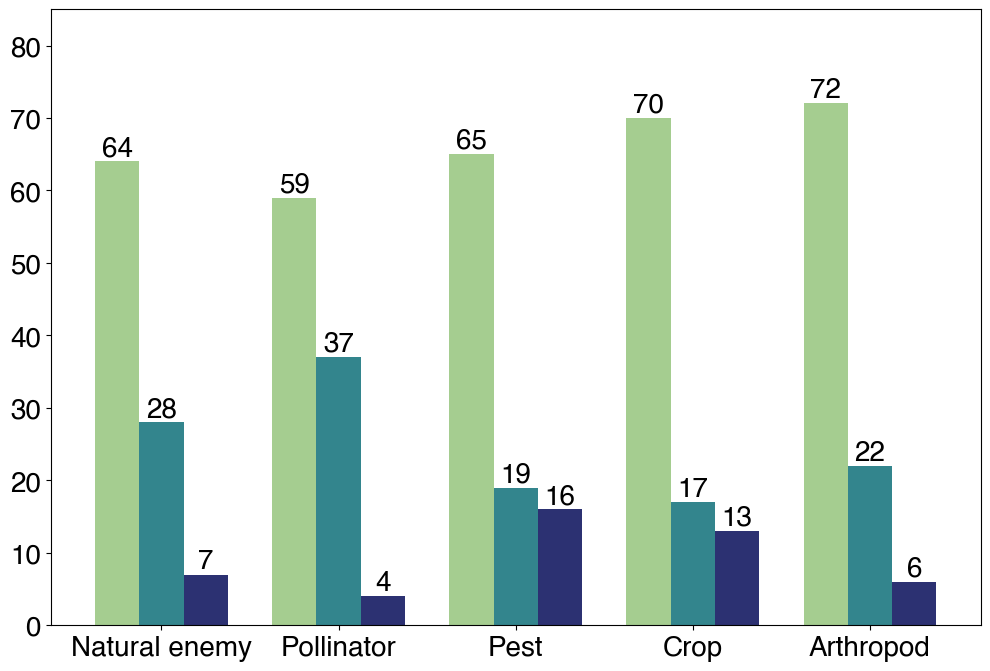

In [153]:
# Plotting effects of local practices for different response types.

plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 20})

ax3 = (
    lit_review_data.groupby(["response_category"])[["local_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(0)
    .unstack()[["NS", "Positive", "Negative"]]
    .loc[['Natural enemy', 'Pollinator', 'Pest', 'Crop', 'Arthropod']]
    .plot(
        kind="bar",
        width=0.75,
        colormap="crest",
        #title="Effects of Local Management Practices, Subset by Response Category",
        #ylabel="Percent of Observations",
        #xlabel="Response Category",
        rot=0,
        figsize=(12, 8),
    )
)

for container in ax3.containers:
    ax3.bar_label(container, fontsize=20, fmt="%d")

plt.xlabel(None)
plt.ylim(0,85)
ax3.get_legend().remove()
#ax3.legend(title="Effect")


In [154]:
response_local_effect = (
    lit_review_data.groupby(["response_category"])[["local_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .unstack()[["NS", "Positive", "Negative"]]
).T

response_local_effect


/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_44984/405427070.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lit_review_data.groupby(["response_category"])[["local_effect"]]


response_category,Arthropod,Crop,Natural enemy,Pest,Pollinator
local_effect,,,,,
NS,71.9,69.6,63.5,64.9,59.2
Positive,21.9,17.4,28.4,18.9,36.7
Negative,6.2,13.0,6.7,16.2,4.2


In [155]:
stats.chisquare(response_local_effect)


Power_divergenceResult(statistic=array([70.6298    , 59.4776    , 49.99127789, 44.9498    , 45.82917083]), pvalue=array([4.60186423e-16, 1.21507549e-13, 1.39486422e-11, 1.73490200e-10,
       1.11769163e-10]))

In [156]:
stats.chisquare(response_local_effect.T)


Power_divergenceResult(statistic=array([ 1.53916743, 10.23730738, 11.19568035]), pvalue=array([0.81968154, 0.03661448, 0.02445067]))

In [157]:
stats.chi2_contingency(response_local_effect)


Chi2ContingencyResult(statistic=22.905862352095806, pvalue=0.003487234041999848, dof=8, expected_freq=array([[65.9915781 , 65.9915781 , 65.06769601, 65.9915781 , 66.05756968],
       [24.72428314, 24.72428314, 24.37814317, 24.72428314, 24.74900742],
       [ 9.28413876,  9.28413876,  9.15416082,  9.28413876,  9.2934229 ]]))

/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_44984/3149479260.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lit_review_data.groupby(["response_category"])[["landscape_effect"]]


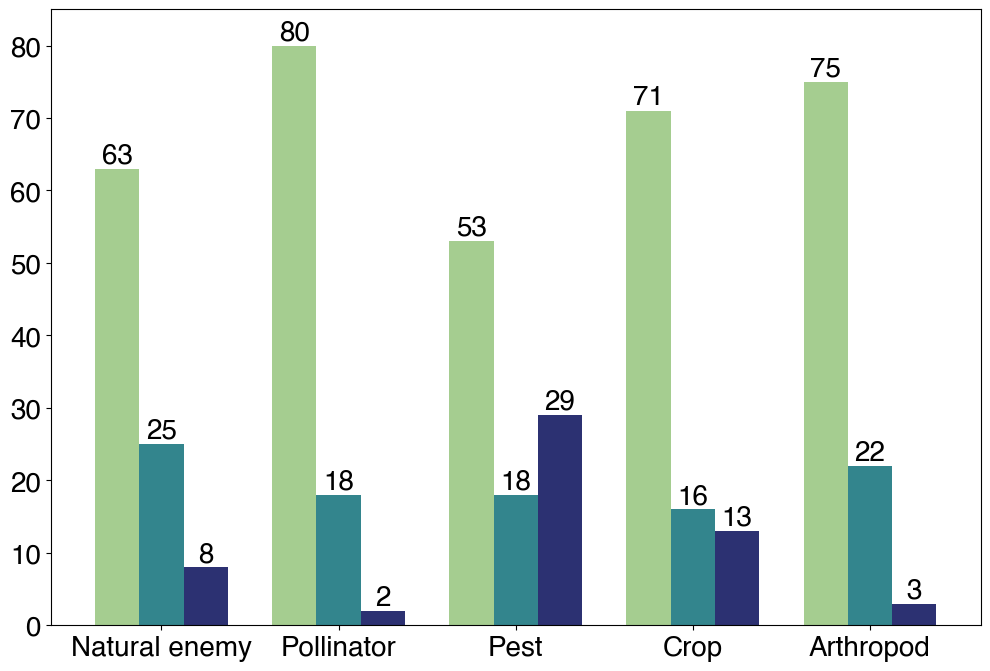

In [158]:
# Plotting effects of local practices across landscape gradients for different response types.

plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 20})

ax3 = (
    lit_review_data.groupby(["response_category"])[["landscape_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(0)
    .unstack()[["NS", "Positive", "Negative"]]
    .loc[['Natural enemy', 'Pollinator', 'Pest', 'Crop', 'Arthropod']]
    .plot(
        kind="bar",
        width=0.75,
        colormap="crest",
        #title="Effects of Landscape Complexity, Subset by Response Category",
        #ylabel="Percent of Observations",
        #xlabel="Response Category",
        rot=0,
        figsize=(12, 8),
    )
)

for container in ax3.containers:
    ax3.bar_label(container, fontsize=20, fmt="%d")

plt.xlabel(None)
plt.ylim(0,85)
ax3.get_legend().remove()
#ax3.get_yaxis().set_ticks([])

#ax3.legend(title="Effect")


In [159]:
response_landscape_effect = (
    lit_review_data.groupby(["response_category"])[["landscape_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .unstack()[["NS", "Positive", "Negative"]]
    .T
)

response_landscape_effect


/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_44984/3477178401.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lit_review_data.groupby(["response_category"])[["landscape_effect"]]


response_category,Arthropod,Crop,Natural enemy,Pest,Pollinator
landscape_effect,,,,,
NS,75.0,70.6,62.6,52.8,80.0
Positive,21.9,16.2,24.6,18.1,17.5
Negative,3.1,13.2,8.2,29.2,2.5


In [160]:
stats.chisquare(response_landscape_effect)


Power_divergenceResult(statistic=array([ 83.4266    ,  62.6312    ,  48.97610063,  18.82377622,
       101.375     ]), pvalue=array([7.65850478e-19, 2.51077458e-14, 2.31726059e-11, 8.17464551e-05,
       9.69836330e-23]))

In [161]:
stats.chisquare(response_landscape_effect.T)


Power_divergenceResult(statistic=array([ 6.74134897,  2.46653103, 42.55266904]), pvalue=array([1.50204565e-01, 6.50638791e-01, 1.28129477e-08]))

In [162]:
stats.chi2_contingency(response_landscape_effect)


Chi2ContingencyResult(statistic=51.205510973100075, pvalue=2.3953899852572845e-08, dof=8, expected_freq=array([[68.81937437, 68.81937437, 65.65368315, 68.88819374, 68.81937437],
       [19.83854692, 19.83854692, 18.92597376, 19.85838547, 19.83854692],
       [11.34207871, 11.34207871, 10.82034309, 11.35342079, 11.34207871]]))

/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_44984/1492134937.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lit_review_data.groupby(["response_type"])[["local_effect"]]


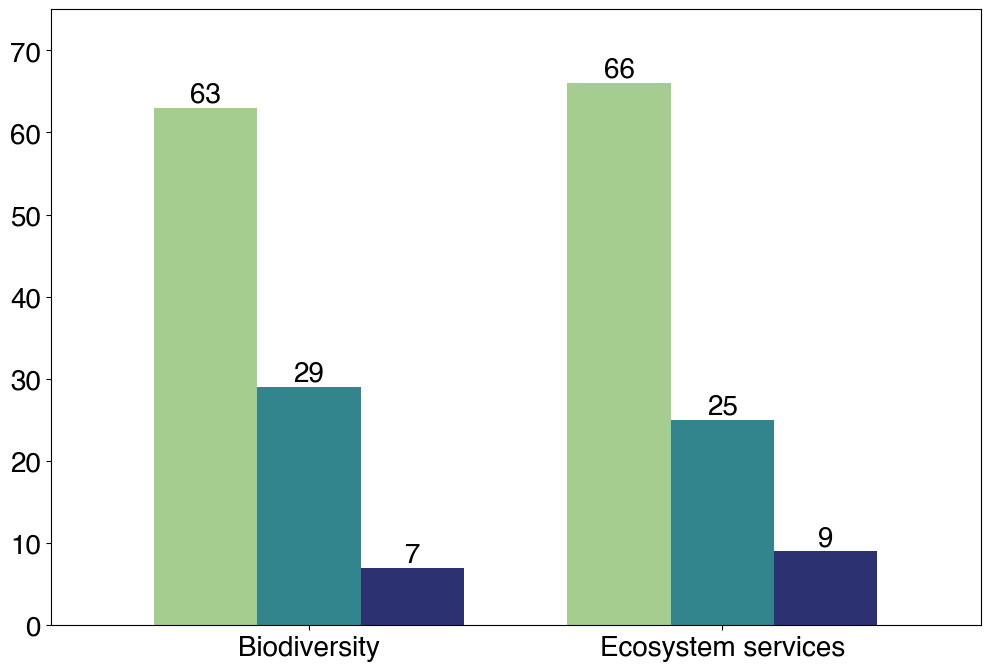

In [163]:
# Plotting local effects of local practices.
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 20})

ax9 = (
    lit_review_data.groupby(["response_type"])[["local_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(0)
    .unstack()[["NS", "Positive", "Negative"]]
    .plot(
        kind="bar",
        width=0.75,
        colormap="crest",
        #title="Effects of Local Management on Response Type",
        #ylabel="Percent of Observations",
        #xlabel="Response Type",
        rot=0,
        figsize=(12, 8)
    )
)

plt.xlabel(None)
plt.ylim(0, 75)

for container in ax9.containers:
    ax9.bar_label(container, fontsize=20, fmt="%d")

ax9.get_legend().remove()
#ax9.legend(title="Effect")


In [164]:
response_type_local_effect = (
    lit_review_data.groupby(["response_type"])[["local_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .unstack()[["NS", "Positive", "Negative"]]
    .T
)

response_type_local_effect


/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_44984/349916885.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lit_review_data.groupby(["response_type"])[["local_effect"]]


response_type,Biodiversity,Ecosystem services
local_effect,,
NS,62.7,65.9
Positive,28.8,24.8
Negative,7.3,9.3


In [165]:
stats.chisquare(response_type_local_effect)


Power_divergenceResult(statistic=array([47.37469636, 51.3302    ]), pvalue=array([5.16078059e-11, 7.14148770e-12]))

In [166]:
stats.chisquare(response_type_local_effect.T)


Power_divergenceResult(statistic=array([0.07962675, 0.29850746, 0.24096386]), pvalue=array([0.77780387, 0.58481962, 0.62351083]))

In [167]:
stats.chi2_contingency(response_type_local_effect)


Chi2ContingencyResult(statistic=0.6118769012522832, pvalue=0.7364319449863099, dof=2, expected_freq=array([[63.91187123, 64.68812877],
       [26.63822938, 26.96177062],
       [ 8.2498994 ,  8.3501006 ]]))

/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_44984/3406399805.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lit_review_data.groupby(["response_type"])[["landscape_effect"]]


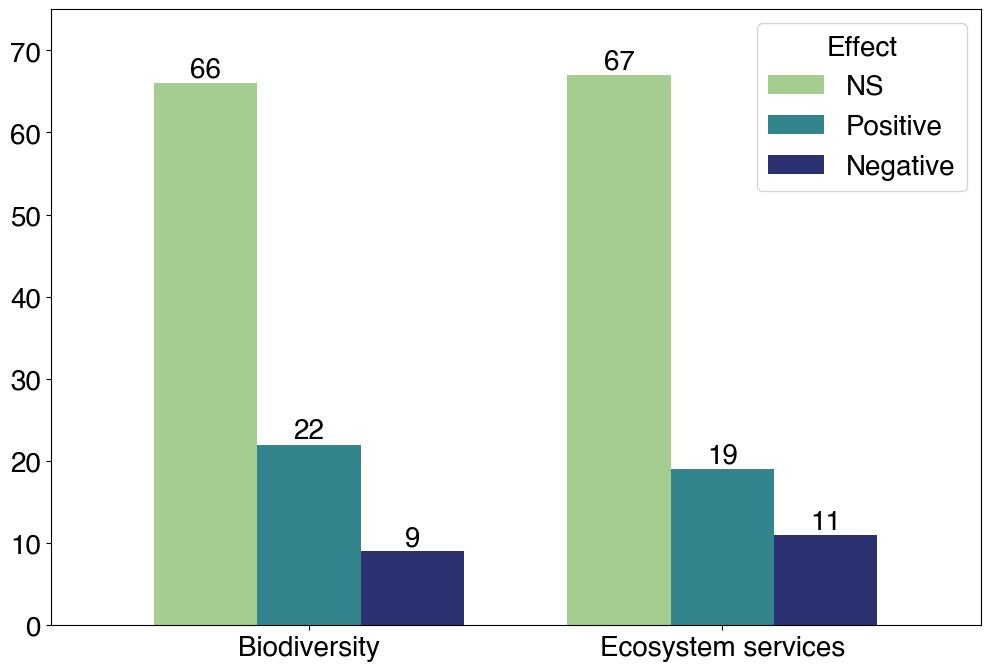

In [168]:
# Plotting local effects of local practices.
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 20})

ax10 = (
    lit_review_data.groupby(["response_type"])[["landscape_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(0)
    .unstack()[["NS", "Positive", "Negative"]]
    .plot(
        kind="bar",
        width=0.75,
        colormap="crest",
        #title="Effects of Landscape Complexity on Response Type",
        #ylabel="Percent of Observations",
        #xlabel="Response Type",
        rot=0,
        figsize=(12, 8),
    )
)

plt.xlabel(None)
#ax10.get_yaxis().set_ticks([])
plt.ylim(0,75)

for container in ax10.containers:
    ax10.bar_label(container, fontsize=20, fmt="%d")

ax10.xaxis.labelpad = 100

ax10.legend(title="Effect")


In [33]:
response_type_landscape_effect = (
    lit_review_data.groupby(["response_type"])[["landscape_effect"]]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .unstack()[["NS", "Positive", "Negative"]]
    .T
)

response_type_landscape_effect


response_type,Biodiversity,Ecosystem services
landscape_effect,,
NS,67.0,68.9
Positive,23.3,20.0
Negative,9.8,11.1


In [34]:
stats.chisquare(response_type_landscape_effect)


Power_divergenceResult(statistic=array([53.58421578, 58.1126    ]), pvalue=array([2.31385097e-12, 2.40441399e-13]))

In [35]:
stats.chisquare(response_type_landscape_effect.T)


Power_divergenceResult(statistic=array([0.02656365, 0.25150115, 0.08086124]), pvalue=array([0.87053136, 0.61602005, 0.77613365]))

In [36]:
stats.chi2_contingency(response_type_landscape_effect)


Chi2ContingencyResult(statistic=0.3588761631129029, pvalue=0.8357396970423747, dof=2, expected_freq=array([[67.98395802, 67.91604198],
       [21.66081959, 21.63918041],
       [10.45522239, 10.44477761]]))

**Mako Color Hex Codes**

- '0B0405'  
- '357BA3'  
- 'DEF5E5'

In [64]:
lit_review_data.insert(
    loc=14,
    column="gradient_range",
    value=lit_review_data["maximum_complexity"] - lit_review_data["minimum_complexity"],
)


Text(0, 0.5, 'Number of observations')

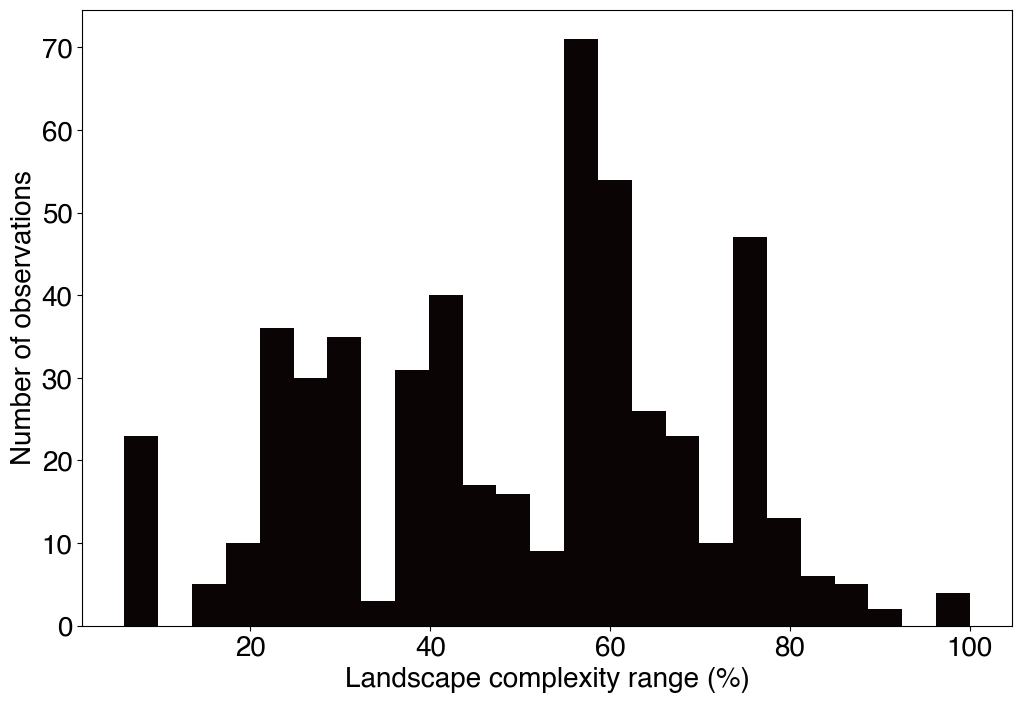

In [71]:
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(12, 8))
#plt.title("Distribution of landscape complexity ranges")

plt.hist(
    lit_review_data["gradient_range"], alpha=1, bins=25, color="#0B0405"
)

plt.xlabel("Landscape complexity range (%)")
plt.ylabel("Number of observations")



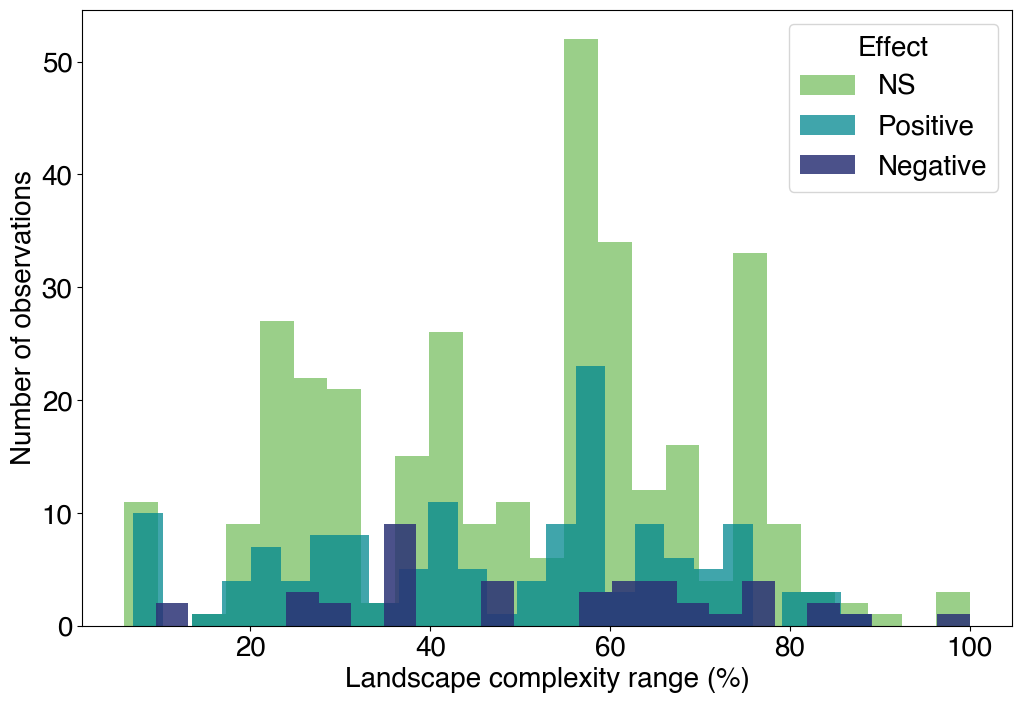

In [66]:
# Gradient ranges for local effect observations

plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(12, 8))
#plt.title("Landscape Complexity Ranges for Local Effect Observations")

plt.hist(
    lit_review_data.where(lit_review_data["local_effect"] == "NS")["gradient_range"],
    alpha=1,
    label="NS",
    bins=25,
    color="#9ACF89",
)

plt.hist(
    lit_review_data.where(lit_review_data["local_effect"] == "Positive")[
        "gradient_range"
    ],
    alpha=0.75,
    label="Positive",
    bins=25,
    color="#00878F",
)

plt.hist(
    lit_review_data.where(lit_review_data["local_effect"] == "Negative")[
        "gradient_range"
    ],
    alpha=0.85,
    label="Negative",
    bins=25,
    color="#2B3276",
)

plt.legend(title="Effect", loc="upper right")
plt.xlabel("Landscape complexity range (%)")
plt.ylabel("Number of observations")
plt.show()


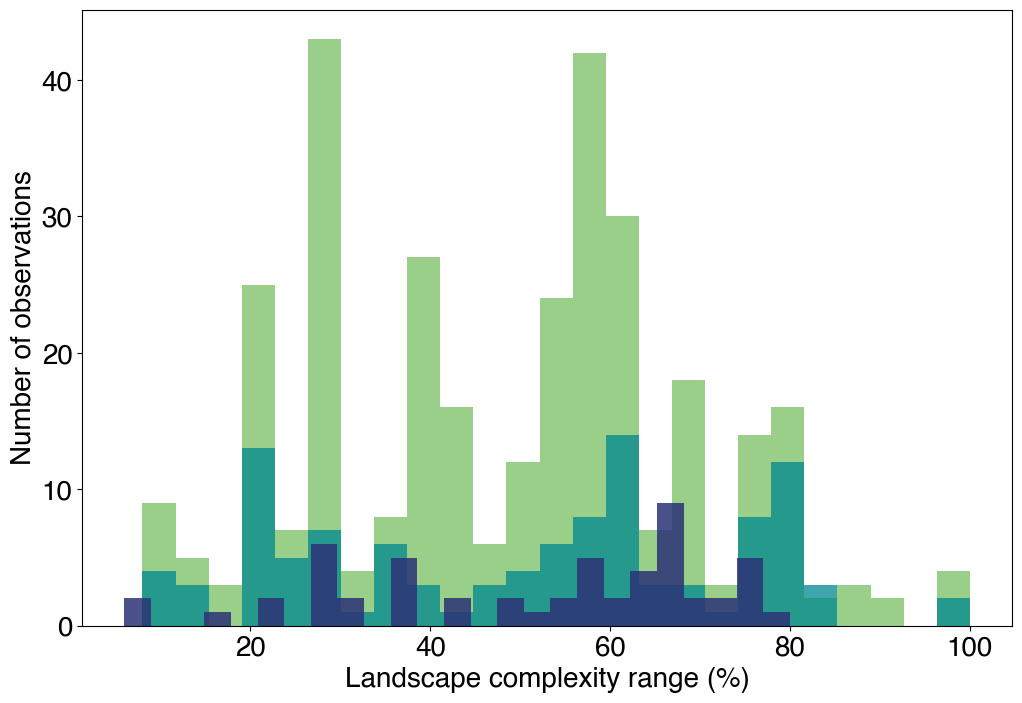

In [40]:
# Gradient ranges for landscape complexity effect observations

plt.figure(figsize=(12, 8))
#plt.title("Landscape Complexity Ranges for Landscape Complexity Effect Observations")

plt.hist(
    lit_review_data.where(lit_review_data["landscape_effect"] == "NS")[
        "gradient_range"
    ],
    alpha=1,
    label="NS",
    bins=25,
    color="#9ACF89",
)

plt.hist(
    lit_review_data.where(lit_review_data["landscape_effect"] == "Positive")[
        "gradient_range"
    ],
    alpha=0.75,
    label="Positive",
    bins=25,
    color="#00878F",
)

plt.hist(
    lit_review_data.where(lit_review_data["landscape_effect"] == "Negative")[
        "gradient_range"
    ],
    alpha=0.85,
    label="Negative",
    bins=25,
    color="#2B3276",
)

#plt.legend(title="Effect", loc="upper right")
plt.xlabel("Landscape complexity range (%)")
plt.ylabel("Number of observations")
plt.show()




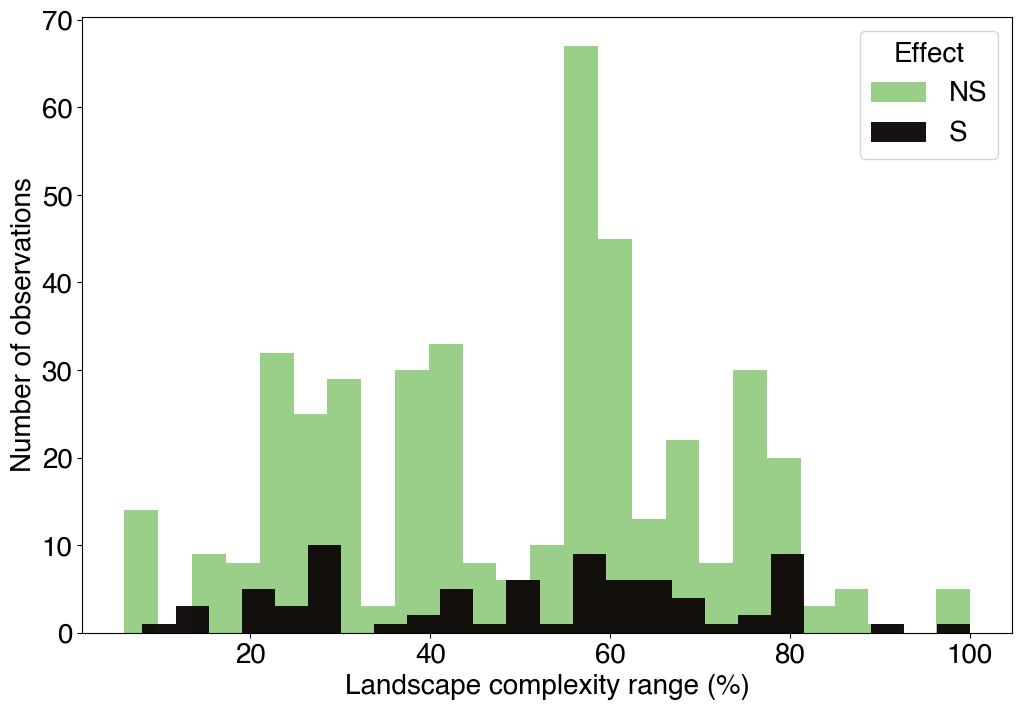

In [41]:
# Gradient ranges for interaction effect

plt.figure(figsize=(12, 8))
#plt.title("Landscape Complexity Ranges for Interaction Effect Observations")

plt.hist(
    lit_review_data.where(lit_review_data["interaction_effect"] == "NS")[
        "gradient_range"
    ],
    alpha=1,
    label="NS",
    bins=25,
    color="#9ACF89",
)

plt.hist(
    lit_review_data.where(lit_review_data["interaction_effect"] == "S")[
        "gradient_range"
    ],
    alpha=0.95,
    label="S",
    bins=25,
    color="#0B0405",
)

plt.legend(title="Effect", loc="upper right")
plt.xlabel("Landscape complexity range (%)")
plt.ylabel("Number of observations")
plt.show()


In [179]:
gradient_range_array = lit_review_data.gradient_range.sort_values(ascending=True)

gradient_range_array[np.logical_not(np.isnan(gradient_range_array))].value_counts()


AttributeError: 'DataFrame' object has no attribute 'gradient_range'

In [58]:
interaction_data = pd.read_csv("lit_review_interactions.csv")
interaction_data


,Obs_ID,Title,Author,Year,Comparison,Response,Sample Size,Unit,Response Type,Response Category,...,Landscape Effect,Interaction Details,Interaction Effect,Simple_Collapsed,Intermediate_Collapsed,Complex_Collapsed,Simple,Intermediate,Complex,Description
0,Obs_1,Agricultural intensification and biodiversity ...,Flohre et al.,2011,Conventional,Beta diversity (carabids),1350,Fields,Biodiversity,Natural enemy,...,NS,Medium intensity has a negative effect on dive...,More negative local effect in complex landscapes,NP,NP,NP,NS,Negative,NS,β diversities of carabids were only decreased ...
1,Obs_2,Agricultural landscape composition affects the...,Gervais et al.,2020,Conventional,Pollen load diversity,80,Colonies,Ecosystem Services,Pollinator,...,NS,"Positive when local species richness was high,...",More positive local effect in complex landscapes,NP,Positive,Positive,Negative,Positive,Positive,Landscape composition as well as local floral ...
2,Obs_3,"Agroecological farming, flowering phenology an...",Monticelli et al.,2022,Control,Seed yield/plant C. segetum,114,Plants,Ecosystem Services,Crop,...,Positive,Positive effect of local factor in more comple...,More positive local effect in complex landscapes,NP,Positive,Positive,NS,Positive,Positive,C. segetum seed yield increased with flowering...
3,Obs_4,"Agroecological farming, flowering phenology an...",Monticelli et al.,2022,Control,Pollinator abundance C. segetum,16,Sites,Biodiversity,Pollinator,...,Negative,Positive effect of local factor in more simple...,More positive local effect in simple landscapes,Positive,Positive,NP,Positive,Positive,Negative,The abundance of pollinators on C. segetum rel...
4,Obs_5,"Agroecological farming, flowering phenology an...",Monticelli et al.,2022,Control,Pollinator abundance C. jacea,16,Sites,Biodiversity,Pollinator,...,NS,Positive effect of local factor in more simple...,More positive local effect in simple landscapes,Positive,NP,NP,Positive,Negative,Negative,A significant interaction revealed that C. seg...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,Obs_79,The effect of organic farming on butterfly div...,Rundlof & Smith,2006,Conventional,Butterfly richness,12,Paired Fields,Biodiversity,Pollinator,...,Positive,More positive in homogenous ~30% non-arable land,More positive local effect in simple landscapes,Positive,NP,NP,Positive,NS,NS,Both species richness and abundance of butterf...
79,Obs_80,The effect of organic farming on butterfly div...,Rundlof & Smith,2006,Conventional,Butterfly abundance,12,Paired Fields,Biodiversity,Pollinator,...,Positive,More positive in homogenous ~30% non-arable land,More positive local effect in simple landscapes,Positive,NP,NP,Positive,NS,NS,Both species richness and abundance of butterf...
80,Obs_81,The taxon- and functional trait-dependent effe...,Zhang et al.,2020,Control,Abundance (spider),36,Fields,Biodiversity,Natural enemy,...,Negative,"Positive in grassy and woodland margins, negat...",More positive local effect in complex landscapes,NP,NP,Positive,Negative,NS,Positive,An interaction effect between landscape compos...
81,Obs_82,Unpacking the push-pull system: Assessing the ...,Kebede et al.,2018,Control,Stemborer infestation,12,Fields,Biodiversity,Pest,...,Positive,More positive in intermediate landscapes.,More positive local effect in intermediate lan...,NP,Positive,NP,NS,Positive,NS,Highest length of tunnelling in the simple lan...


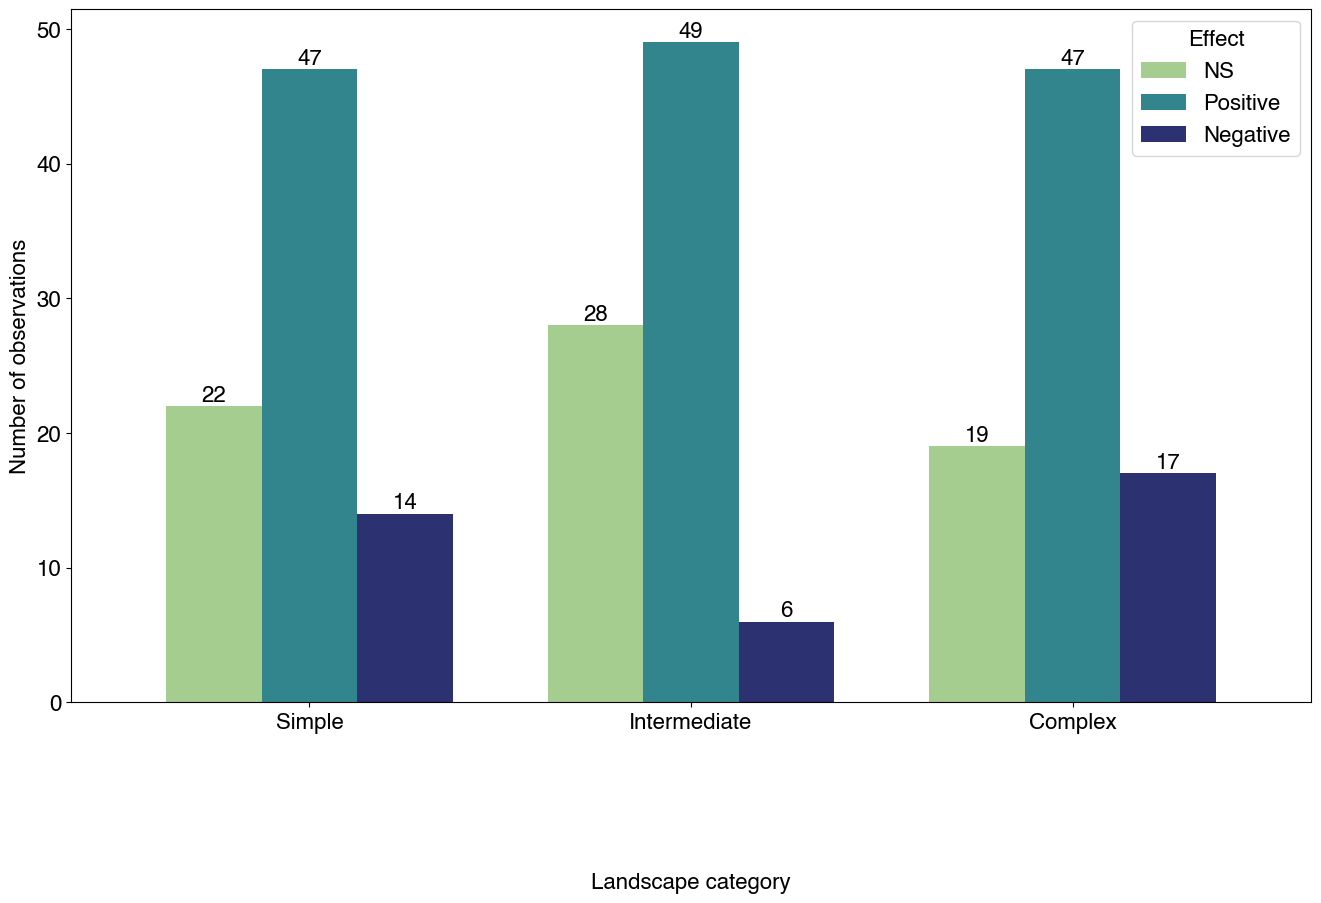

In [169]:
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 16})

ax11 = (
    interaction_data[["Simple", "Intermediate", "Complex"]]
    .apply(pd.Series.value_counts)
    .T[["NS", "Positive", "Negative"]]
    .plot(
        kind="bar",
        colormap="crest",
        width=0.75,
        #title="Significant local and landscape interaction observations",
        ylabel="Number of observations",
        xlabel="Landscape category",
        rot=0,
        figsize=(16, 9),
    )
)

ax11.xaxis.labelpad = 100

for container in ax11.containers:
    ax11.bar_label(container, fontsize=16)

ax11.legend(title="Effect")


In [45]:
all_interactions = (
    interaction_data[["Simple", "Intermediate", "Complex"]]
    .apply(pd.Series.value_counts)
    .T[["NS", "Positive", "Negative"]]
    .T
)

all_interactions


,Simple,Intermediate,Complex
NS,22,28,19
Positive,47,49,47
Negative,14,6,17


In [46]:
stats.chisquare(all_interactions)


Power_divergenceResult(statistic=array([21.42168675, 33.42168675, 20.3373494 ]), pvalue=array([2.23017954e-05, 5.52806238e-08, 3.83531192e-05]))

In [47]:
stats.chisquare(all_interactions.T)


Power_divergenceResult(statistic=array([1.82608696, 0.05594406, 5.24324324]), pvalue=array([0.40130101, 0.97241557, 0.0726849 ]))

In [48]:
arthropod_interactions = (
    interaction_data.where(interaction_data["Response Category"] == "Arthropod")[
        ["Simple", "Intermediate", "Complex"]
    ]
    .apply(pd.Series.value_counts)
    .T[["NS", "Positive", "Negative"]]
    .fillna(0)
    .T
)

arthropod_interactions


,Simple,Intermediate,Complex
NS,0.0,2.0,0.0
Positive,3.0,2.0,3.0
Negative,1.0,0.0,1.0


In [49]:
stats.chisquare(arthropod_interactions)


Power_divergenceResult(statistic=array([3.5, 2. , 3.5]), pvalue=array([0.17377394, 0.36787944, 0.17377394]))

In [50]:
stats.chisquare(arthropod_interactions.T)


Power_divergenceResult(statistic=array([4.  , 0.25, 1.  ]), pvalue=array([0.13533528, 0.8824969 , 0.60653066]))

In [51]:
stats.chi2_contingency(arthropod_interactions)


Chi2ContingencyResult(statistic=5.250000000000001, pvalue=0.2625941192491615, dof=4, expected_freq=array([[0.66666667, 0.66666667, 0.66666667],
       [2.66666667, 2.66666667, 2.66666667],
       [0.66666667, 0.66666667, 0.66666667]]))

In [52]:
crop_interaction = (
    interaction_data.where(interaction_data["Response Category"] == "Crop")[
        ["Simple", "Intermediate", "Complex"]
    ]
    .apply(pd.Series.value_counts)
    .T[["NS", "Positive", "Negative"]]
    .T
)

crop_interaction


,Simple,Intermediate,Complex
NS,4,5,2
Positive,1,4,6
Negative,5,1,2


In [53]:
stats.chisquare(crop_interaction)


Power_divergenceResult(statistic=array([2.6, 2.6, 3.2]), pvalue=array([0.27253179, 0.27253179, 0.20189652]))

In [54]:
stats.chisquare(crop_interaction.T)


Power_divergenceResult(statistic=array([1.27272727, 3.45454545, 3.25      ]), pvalue=array([0.52921334, 0.17776857, 0.19691168]))

In [55]:
stats.chi2_contingency(crop_interaction)


Chi2ContingencyResult(statistic=7.977272727272728, pvalue=0.09241428016463347, dof=4, expected_freq=array([[3.66666667, 3.66666667, 3.66666667],
       [3.66666667, 3.66666667, 3.66666667],
       [2.66666667, 2.66666667, 2.66666667]]))

In [56]:
pollinator_interaction = (
    interaction_data.where(interaction_data["Response Category"] == "Pollinator")[
        ["Simple", "Intermediate", "Complex"]
    ]
    .apply(pd.Series.value_counts)
    .T[["NS", "Positive", "Negative"]]
    .T
)

pollinator_interaction


,Simple,Intermediate,Complex
NS,4,6,6
Positive,18,16,13
Negative,2,2,5


In [57]:
stats.chisquare(pollinator_interaction)


Power_divergenceResult(statistic=array([19.  , 13.  ,  4.75]), pvalue=array([7.48518299e-05, 1.50343919e-03, 9.30144892e-02]))

In [58]:
stats.chisquare(pollinator_interaction.T)


Power_divergenceResult(statistic=array([0.5       , 0.80851064, 2.        ]), pvalue=array([0.77880078, 0.66747368, 0.36787944]))

In [59]:
stats.chi2_contingency(pollinator_interaction)


Chi2ContingencyResult(statistic=3.3085106382978724, pvalue=0.5075849533928345, dof=4, expected_freq=array([[ 5.33333333,  5.33333333,  5.33333333],
       [15.66666667, 15.66666667, 15.66666667],
       [ 3.        ,  3.        ,  3.        ]]))

In [60]:
natural_enemy_interaction = (
    interaction_data.where(interaction_data["Response Category"] == "Natural enemy")[
        ["Simple", "Intermediate", "Complex"]
    ]
    .apply(pd.Series.value_counts)
    .T[["NS", "Positive", "Negative"]]
    .T
)

natural_enemy_interaction


,Simple,Intermediate,Complex
NS,12,12,9
Positive,21,23,23
Negative,5,3,6


In [61]:
stats.chisquare(natural_enemy_interaction)


Power_divergenceResult(statistic=array([10.15789474, 15.84210526, 13.        ]), pvalue=array([0.00622646, 0.00036302, 0.00150344]))

In [62]:
stats.chisquare(natural_enemy_interaction.T)


Power_divergenceResult(statistic=array([0.54545455, 0.11940299, 1.        ]), pvalue=array([0.76130039, 0.9420457 , 0.60653066]))

In [63]:
stats.chi2_contingency(natural_enemy_interaction)


Chi2ContingencyResult(statistic=1.664857530529172, pvalue=0.7970909556182693, dof=4, expected_freq=array([[11.        , 11.        , 11.        ],
       [22.33333333, 22.33333333, 22.33333333],
       [ 4.66666667,  4.66666667,  4.66666667]]))

In [64]:
pest_interaction = (
    interaction_data.where(interaction_data["Response Category"] == "Pest")[
        ["Simple", "Intermediate", "Complex"]
    ]
    .apply(pd.Series.value_counts)
    .T[["NS", "Positive", "Negative"]]
    .T
).fillna(0)

pest_interaction


,Simple,Intermediate,Complex
NS,2.0,3.0,2.0
Positive,4.0,4.0,2.0
Negative,1.0,0.0,3.0


In [65]:
stats.chisquare(pest_interaction)

Power_divergenceResult(statistic=array([2.        , 3.71428571, 0.28571429]), pvalue=array([0.36787944, 0.15611805, 0.8668779 ]))

In [66]:
stats.chisquare(pest_interaction.T)

Power_divergenceResult(statistic=array([0.28571429, 0.8       , 3.5       ]), pvalue=array([0.8668779 , 0.67032005, 0.17377394]))

In [67]:
stats.chi2_contingency(pest_interaction)

Chi2ContingencyResult(statistic=4.585714285714285, pvalue=0.3325046205905675, dof=4, expected_freq=array([[2.33333333, 2.33333333, 2.33333333],
       [3.33333333, 3.33333333, 3.33333333],
       [1.33333333, 1.33333333, 1.33333333]]))

In [68]:
intensity_interactions = interaction_data.where(
    interaction_data["Local Strategy"] == "Intensity"
)[["Simple", "Intermediate", "Complex"]].apply(pd.Series.value_counts)

intensity_interactions


,Simple,Intermediate,Complex
Positive,27,21,20
NS,5,13,9
Negative,4,2,7


In [69]:
stats.chisquare(intensity_interactions)


Power_divergenceResult(statistic=array([28.16666667, 15.16666667,  8.16666667]), pvalue=array([7.65043354e-07, 5.08862186e-04, 1.68512013e-02]))

In [70]:
stats.chisquare(intensity_interactions.T)


Power_divergenceResult(statistic=array([1.26470588, 3.55555556, 2.92307692]), pvalue=array([0.53134012, 0.16901332, 0.23187926]))

In [71]:
stats.chi2_contingency(intensity_interactions)


Chi2ContingencyResult(statistic=7.74333836098542, pvalue=0.10144560306176552, dof=4, expected_freq=array([[22.66666667, 22.66666667, 22.66666667],
       [ 9.        ,  9.        ,  9.        ],
       [ 4.33333333,  4.33333333,  4.33333333]]))

In [72]:
structure_interactions = (
    interaction_data.where(interaction_data["Local Strategy"] == "Structure")[
        ["Simple", "Intermediate", "Complex"]
    ]
    .apply(pd.Series.value_counts)
    .fillna(0)
)

structure_interactions


,Simple,Intermediate,Complex
NS,0.0,1.0,0.0
Negative,1.0,0.0,0.0
Positive,3.0,3.0,4.0


In [73]:
stats.chisquare(structure_interactions)


Power_divergenceResult(statistic=array([3.5, 3.5, 8. ]), pvalue=array([0.17377394, 0.17377394, 0.01831564]))

In [74]:
stats.chisquare(structure_interactions.T)


Power_divergenceResult(statistic=array([2. , 2. , 0.2]), pvalue=array([0.36787944, 0.36787944, 0.90483742]))

In [75]:
stats.chi2_contingency(structure_interactions)


Chi2ContingencyResult(statistic=4.2, pvalue=0.37961492758424376, dof=4, expected_freq=array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [3.33333333, 3.33333333, 3.33333333]]))

In [76]:
floral_interactions = interaction_data.where(
    interaction_data["Local Strategy"] == "Floral"
)[["Simple", "Intermediate", "Complex"]].apply(pd.Series.value_counts)

floral_interactions


,Simple,Intermediate,Complex
NS,12,9,9
Negative,6,2,7
Positive,12,19,14


In [77]:
stats.chisquare(floral_interactions)


Power_divergenceResult(statistic=array([ 2.4, 14.6,  2.6]), pvalue=array([0.30119421, 0.00067554, 0.27253179]))

In [78]:
stats.chisquare(floral_interactions.T)


Power_divergenceResult(statistic=array([0.6       , 2.8       , 1.73333333]), pvalue=array([0.74081822, 0.24659696, 0.42035038]))

In [79]:
stats.chi2_contingency(floral_interactions)


Chi2ContingencyResult(statistic=5.133333333333333, pvalue=0.27388821949831943, dof=4, expected_freq=array([[10., 10., 10.],
       [ 5.,  5.,  5.],
       [15., 15., 15.]]))

In [80]:
diversity_interactions = interaction_data.where(
    interaction_data["Local Strategy"] == "Diversity"
)[["Simple", "Intermediate", "Complex"]].apply(pd.Series.value_counts)

diversity_interactions


,Simple,Intermediate,Complex
NS,5,5,1
Negative,3,2,3
Positive,5,6,9


In [81]:
stats.chisquare(diversity_interactions)


Power_divergenceResult(statistic=array([0.61538462, 2.        , 8.        ]), pvalue=array([0.73514148, 0.36787944, 0.01831564]))

In [82]:
stats.chisquare(diversity_interactions.T)


Power_divergenceResult(statistic=array([2.90909091, 0.25      , 1.3       ]), pvalue=array([0.23350648, 0.8824969 , 0.52204578]))

In [83]:
stats.chi2_contingency(diversity_interactions)


Chi2ContingencyResult(statistic=4.459090909090909, pvalue=0.3474258377291349, dof=4, expected_freq=array([[3.66666667, 3.66666667, 3.66666667],
       [2.66666667, 2.66666667, 2.66666667],
       [6.66666667, 6.66666667, 6.66666667]]))

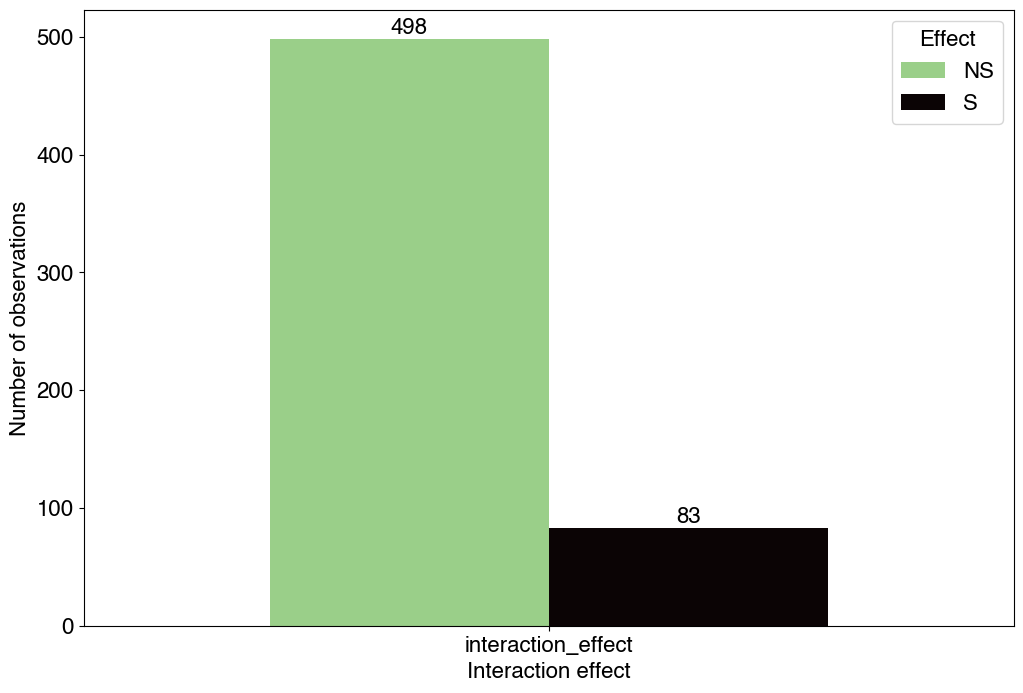

In [176]:
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 16})

ax11 = lit_review_data[['interaction_effect']].apply(pd.Series.value_counts).T.plot(
        kind="bar",
        color=["#9ACF89", "#0B0405"],
        width=0.75,
        ylabel="Number of observations",
        xlabel="Interaction effect",
        rot=0,
        figsize=(12, 8),
    )

for container in ax11.containers:
    ax11.bar_label(container, fontsize=16)

ax11.legend(title="Effect", labels = ['NS', 'S'])


In [36]:
sig_interactions = lit_review_data.groupby('interaction_effect').count()['response']
sig_interactions

interaction_effect
NS    498
S      83
Name: response, dtype: int64

(array([0, 1]), [Text(0, 0, 'NS'), Text(1, 0, 'S')])

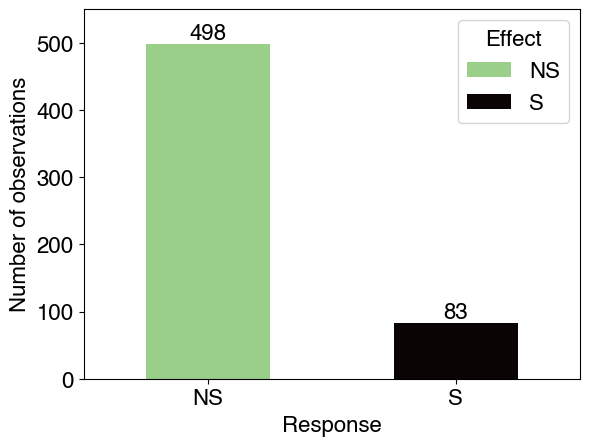

In [39]:
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 16})

ax = sig_interactions.plot.bar(color=["#9ACF89", "#0B0405"])

for container in ax.containers:
    ax.bar_label(container, fontsize=16)

handles = [
    Patch(facecolor="#9ACF89", label="NS"),
    Patch(facecolor="#0B0405", label="S")
]

plt.legend(title="Effect", handles=handles)
ax.set_ylim(0, 550)
ax.set_xlabel('Response')
ax.set_ylabel('Number of observations')
plt.xticks(rotation=0)


In [137]:
interaction_data[["Simple", "Intermediate", "Complex"]].apply(pd.Series.value_counts).T[["NS", "Positive", "Negative"]]

,NS,Positive,Negative
Simple,22,47,14
Intermediate,28,49,6
Complex,19,47,17


In [8]:
np.average(lit_review_data['minimum_complexity'].dropna())

10.935785288270377

In [10]:
np.std(lit_review_data['minimum_complexity'].dropna())

14.705842475429598

In [9]:
np.average(lit_review_data['maximum_complexity'].dropna())

60.416103379721676

In [11]:
np.std(lit_review_data['maximum_complexity'].dropna())

23.142864482739594

# Recategorized Interactions

In [173]:
recat = pd.read_csv('lit_review_recat_results.csv')
recat = clean_columns(recat)
recat.head()

,title,author_s,year,simple_pos,simple_ns,simple_neg,intermediate_pos,intermediate_ns,intermediate_neg,complex_pos,complex_ns,complex_neg
0,Benefits of increased cover crop diversity for...,Beaumelle et al.,2021,0,0,0,1,0,1,1,0,0
1,Benefits of increased cover crop diversity for...,Beaumelle et al.,2021,0,0,0,1,0,1,0,0,1
2,Pest control experiments show benefits of comp...,Chaplin-Kramer & Kremen,2012,0,1,0,0,1,0,1,0,0
3,Organic Farming: Biodiversity Impacts Can Depe...,Feber et al.,2015,0,0,0,0,0,0,1,0,0
4,Organic Farming: Biodiversity Impacts Can Depe...,Feber et al.,2015,0,0,0,1,0,0,1,0,0


In [174]:
recat = recat.merge(lit_review_data[['title', 'local_strategy']].drop_duplicates(), on='title', how='left')
recat.head()

,title,author_s,year,simple_pos,simple_ns,simple_neg,intermediate_pos,intermediate_ns,intermediate_neg,complex_pos,complex_ns,complex_neg,local_strategy
0,Benefits of increased cover crop diversity for...,Beaumelle et al.,2021,0,0,0,1,0,1,1,0,0,Diversity
1,Benefits of increased cover crop diversity for...,Beaumelle et al.,2021,0,0,0,1,0,1,0,0,1,Diversity
2,Pest control experiments show benefits of comp...,Chaplin-Kramer & Kremen,2012,0,1,0,0,1,0,1,0,0,Diversity
3,Organic Farming: Biodiversity Impacts Can Depe...,Feber et al.,2015,0,0,0,0,0,0,1,0,0,Intensity
4,Organic Farming: Biodiversity Impacts Can Depe...,Feber et al.,2015,0,0,0,1,0,0,1,0,0,Intensity


In [175]:
recat = recat.drop(['author_s', 'year'], axis = 1)
recat.head()

,title,simple_pos,simple_ns,simple_neg,intermediate_pos,intermediate_ns,intermediate_neg,complex_pos,complex_ns,complex_neg,local_strategy
0,Benefits of increased cover crop diversity for...,0,0,0,1,0,1,1,0,0,Diversity
1,Benefits of increased cover crop diversity for...,0,0,0,1,0,1,0,0,1,Diversity
2,Pest control experiments show benefits of comp...,0,1,0,0,1,0,1,0,0,Diversity
3,Organic Farming: Biodiversity Impacts Can Depe...,0,0,0,0,0,0,1,0,0,Intensity
4,Organic Farming: Biodiversity Impacts Can Depe...,0,0,0,1,0,0,1,0,0,Intensity


In [176]:
recat = recat.melt(id_vars=["title", 'local_strategy'])
recat["landscape"] = recat["variable"].apply(lambda x: x.split("_")[0])
recat["response"] = recat["variable"].apply(lambda x: x.split("_")[1])
recat

,title,local_strategy,variable,value,landscape,response
0,Benefits of increased cover crop diversity for...,Diversity,simple_pos,0,simple,pos
1,Benefits of increased cover crop diversity for...,Diversity,simple_pos,0,simple,pos
2,Pest control experiments show benefits of comp...,Diversity,simple_pos,0,simple,pos
3,Organic Farming: Biodiversity Impacts Can Depe...,Intensity,simple_pos,0,simple,pos
4,Organic Farming: Biodiversity Impacts Can Depe...,Intensity,simple_pos,0,simple,pos
...,...,...,...,...,...,...
490,Landscape diversity and crop vigor outweigh in...,Floral,complex_neg,0,complex,neg
491,Landscape diversity and crop vigor outweigh in...,Floral,complex_neg,0,complex,neg
492,Landscape diversity and crop vigor outweigh in...,Floral,complex_neg,0,complex,neg
493,Mixed effects of organic farming and landscape...,Intensity,complex_neg,0,complex,neg


In [177]:
recat = recat.drop(['variable'], axis = 1)
recat = recat.loc[recat['value'] != 0]
recat = recat.drop(['value'], axis = 1)

recat.head()

,title,local_strategy,landscape,response
14,Benefits of wildflower areas as overwintering ...,Floral,simple,pos
16,Benefits of wildflower areas as overwintering ...,Floral,simple,pos
18,Benefits of wildflower areas as overwintering ...,Floral,simple,pos
22,Different components of landscape complexity a...,Intensity,simple,pos
23,Different components of landscape complexity a...,Intensity,simple,pos


In [178]:
recat.to_csv('lit_review_recat_for_analysis.csv')

# Recategorized Interactions (TT)

In [189]:
recat_tt = pd.read_csv('lit_review_recat_tt_results.csv')
recat_tt = clean_columns(recat_tt)
recat_tt.head()

,title,author_s,year,simple_pos,simple_ns,simple_neg,intermediate_pos,intermediate_ns,intermediate_neg,complex_pos,complex_ns,complex_neg
0,Benefits of increased cover crop diversity for...,Beaumelle et al.,2021,0,0,0,0,0,0,1,0,1
1,Benefits of increased cover crop diversity for...,Beaumelle et al.,2021,0,0,0,0,0,0,1,0,0
2,Benefits of increased cover crop diversity for...,Beaumelle et al.,2021,0,0,0,0,0,0,1,0,1
3,Benefits of increased cover crop diversity for...,Beaumelle et al.,2021,0,0,0,0,0,0,0,0,1
4,Pest control experiments show benefits of comp...,Chaplin-Kramer & Kremen,2012,0,0,0,0,1,0,1,1,0


In [190]:
recat_tt = recat_tt.merge(lit_review_data[['title', 'local_strategy']].drop_duplicates(), on='title', how='left')
recat_tt.head()

,title,author_s,year,simple_pos,simple_ns,simple_neg,intermediate_pos,intermediate_ns,intermediate_neg,complex_pos,complex_ns,complex_neg,local_strategy
0,Benefits of increased cover crop diversity for...,Beaumelle et al.,2021,0,0,0,0,0,0,1,0,1,Diversity
1,Benefits of increased cover crop diversity for...,Beaumelle et al.,2021,0,0,0,0,0,0,1,0,0,Diversity
2,Benefits of increased cover crop diversity for...,Beaumelle et al.,2021,0,0,0,0,0,0,1,0,1,Diversity
3,Benefits of increased cover crop diversity for...,Beaumelle et al.,2021,0,0,0,0,0,0,0,0,1,Diversity
4,Pest control experiments show benefits of comp...,Chaplin-Kramer & Kremen,2012,0,0,0,0,1,0,1,1,0,Diversity


In [191]:
recat_tt = recat_tt.drop(['author_s', 'year'], axis = 1)
recat_tt.head()

,title,simple_pos,simple_ns,simple_neg,intermediate_pos,intermediate_ns,intermediate_neg,complex_pos,complex_ns,complex_neg,local_strategy
0,Benefits of increased cover crop diversity for...,0,0,0,0,0,0,1,0,1,Diversity
1,Benefits of increased cover crop diversity for...,0,0,0,0,0,0,1,0,0,Diversity
2,Benefits of increased cover crop diversity for...,0,0,0,0,0,0,1,0,1,Diversity
3,Benefits of increased cover crop diversity for...,0,0,0,0,0,0,0,0,1,Diversity
4,Pest control experiments show benefits of comp...,0,0,0,0,1,0,1,1,0,Diversity


In [192]:
recat_tt = recat_tt.melt(id_vars=["title", 'local_strategy'])
recat_tt["landscape"] = recat_tt["variable"].apply(lambda x: x.split("_")[0])
recat_tt["response"] = recat_tt["variable"].apply(lambda x: x.split("_")[1])
recat_tt

,title,local_strategy,variable,value,landscape,response
0,Benefits of increased cover crop diversity for...,Diversity,simple_pos,0,simple,pos
1,Benefits of increased cover crop diversity for...,Diversity,simple_pos,0,simple,pos
2,Benefits of increased cover crop diversity for...,Diversity,simple_pos,0,simple,pos
3,Benefits of increased cover crop diversity for...,Diversity,simple_pos,0,simple,pos
4,Pest control experiments show benefits of comp...,Diversity,simple_pos,0,simple,pos
...,...,...,...,...,...,...
553,Landscape diversity and crop vigor outweigh in...,Floral,complex_neg,0,complex,neg
554,Landscape diversity and crop vigor outweigh in...,Floral,complex_neg,0,complex,neg
555,Landscape diversity and crop vigor outweigh in...,Floral,complex_neg,0,complex,neg
556,Mixed effects of organic farming and landscape...,Intensity,complex_neg,0,complex,neg


In [193]:
recat_tt = recat_tt.drop(['variable'], axis = 1)
recat_tt = recat_tt.loc[recat_tt['value'] != 0]
recat_tt = recat_tt.drop(['value'], axis = 1)

recat_tt.head()

,title,local_strategy,landscape,response
211,Different components of landscape complexity a...,Intensity,intermediate,pos
212,Different components of landscape complexity a...,Intensity,intermediate,pos
215,Diverse landscapes but not wildflower planting...,Floral,intermediate,pos
217,"Agroecological farming, flowering phenology an...",Floral,intermediate,pos
218,"Agroecological farming, flowering phenology an...",Floral,intermediate,pos


In [196]:
recat_tt.to_csv('lit_review_recat_tt_for_analysis.csv')

# Recategorized Interactions (Europe)

In [204]:
recat_europe = pd.read_csv('lit_review_recat_europe_results.csv')
recat_europe = clean_columns(recat_europe)
recat_europe.head()

,title,author_s,year,simple_pos,simple_ns,simple_neg,intermediate_pos,intermediate_ns,intermediate_neg,complex_pos,complex_ns,complex_neg
0,Benefits of increased cover crop diversity for...,Beaumelle et al.,2021,0,0,0,1,0,0,1,0,1
1,Benefits of increased cover crop diversity for...,Beaumelle et al.,2021,0,0,0,0,0,1,1,0,1
2,Organic Farming: Biodiversity Impacts Can Depe...,Feber et al.,2015,0,0,0,1,0,0,1,0,0
3,Organic Farming: Biodiversity Impacts Can Depe...,Feber et al.,2015,0,0,0,0,0,0,1,0,0
4,Does soil biota benefit from organic farming i...,Flohre et al.,2011,0,0,0,1,0,0,0,1,1


In [205]:
recat_europe = recat_europe.merge(lit_review_data[['title', 'local_strategy']].drop_duplicates(), on='title', how='left')
recat_europe.head()

,title,author_s,year,simple_pos,simple_ns,simple_neg,intermediate_pos,intermediate_ns,intermediate_neg,complex_pos,complex_ns,complex_neg,local_strategy
0,Benefits of increased cover crop diversity for...,Beaumelle et al.,2021,0,0,0,1,0,0,1,0,1,Diversity
1,Benefits of increased cover crop diversity for...,Beaumelle et al.,2021,0,0,0,0,0,1,1,0,1,Diversity
2,Organic Farming: Biodiversity Impacts Can Depe...,Feber et al.,2015,0,0,0,1,0,0,1,0,0,Intensity
3,Organic Farming: Biodiversity Impacts Can Depe...,Feber et al.,2015,0,0,0,0,0,0,1,0,0,Intensity
4,Does soil biota benefit from organic farming i...,Flohre et al.,2011,0,0,0,1,0,0,0,1,1,Intensity


In [206]:
recat_europe = recat_europe.drop(['author_s', 'year'], axis = 1)
recat_europe.head()

,title,simple_pos,simple_ns,simple_neg,intermediate_pos,intermediate_ns,intermediate_neg,complex_pos,complex_ns,complex_neg,local_strategy
0,Benefits of increased cover crop diversity for...,0,0,0,1,0,0,1,0,1,Diversity
1,Benefits of increased cover crop diversity for...,0,0,0,0,0,1,1,0,1,Diversity
2,Organic Farming: Biodiversity Impacts Can Depe...,0,0,0,1,0,0,1,0,0,Intensity
3,Organic Farming: Biodiversity Impacts Can Depe...,0,0,0,0,0,0,1,0,0,Intensity
4,Does soil biota benefit from organic farming i...,0,0,0,1,0,0,0,1,1,Intensity


In [207]:
recat_europe = recat_europe.melt(id_vars=["title", 'local_strategy'])
recat_europe["landscape"] = recat_europe["variable"].apply(lambda x: x.split("_")[0])
recat_europe["response"] = recat_europe["variable"].apply(lambda x: x.split("_")[1])
recat_europe

,title,local_strategy,variable,value,landscape,response
0,Benefits of increased cover crop diversity for...,Diversity,simple_pos,0,simple,pos
1,Benefits of increased cover crop diversity for...,Diversity,simple_pos,0,simple,pos
2,Organic Farming: Biodiversity Impacts Can Depe...,Intensity,simple_pos,0,simple,pos
3,Organic Farming: Biodiversity Impacts Can Depe...,Intensity,simple_pos,0,simple,pos
4,Does soil biota benefit from organic farming i...,Intensity,simple_pos,0,simple,pos
...,...,...,...,...,...,...
256,"Agroecological farming, flowering phenology an...",Floral,complex_neg,0,complex,neg
257,"Agroecological farming, flowering phenology an...",Floral,complex_neg,0,complex,neg
258,Annual flower strips support pollinators and p...,Floral,complex_neg,0,complex,neg
259,Annual flower strips support pollinators and p...,Floral,complex_neg,0,complex,neg


In [208]:
recat_europe = recat_europe.drop(['variable'], axis = 1)
recat_europe = recat_europe.loc[recat_europe['value'] != 0]
recat_europe = recat_europe.drop(['value'], axis = 1)

recat_europe.head()

,title,local_strategy,landscape,response
7,Benefits of wildflower areas as overwintering ...,Floral,simple,pos
9,Benefits of wildflower areas as overwintering ...,Floral,simple,pos
11,Benefits of wildflower areas as overwintering ...,Floral,simple,pos
15,Different components of landscape complexity a...,Intensity,simple,pos
16,Different components of landscape complexity a...,Intensity,simple,pos


In [209]:
recat_europe.to_csv('lit_review_recat_europe_for_analysis.csv')

# Recategorized Interactions (North America)

In [211]:
recat_na = pd.read_csv('lit_review_recat_na_results.csv')
recat_na = clean_columns(recat_na)
recat_na.head()

,title,author_s,year,simple_pos,simple_ns,simple_neg,intermediate_pos,intermediate_ns,intermediate_neg,complex_pos,complex_ns,complex_neg
0,Pest control experiments show benefits of comp...,Chaplin-Kramer & Kremen,2012,0,1,0,0,1,0,1,0,0
1,Landscape context shifts the balance of costs ...,Grab et al.,2018,0,1,0,1,0,0,0,1,0
2,Landscape context shifts the balance of costs ...,Grab et al.,2018,0,1,0,1,0,0,0,1,0
3,Landscape context shifts the balance of costs ...,Grab et al.,2018,0,0,1,1,0,0,0,1,0
4,Landscape context shifts the balance of costs ...,Grab et al.,2018,0,0,1,1,0,0,0,0,1


In [212]:
recat_na = recat_na.merge(lit_review_data[['title', 'local_strategy']].drop_duplicates(), on='title', how='left')
recat_na.head()

,title,author_s,year,simple_pos,simple_ns,simple_neg,intermediate_pos,intermediate_ns,intermediate_neg,complex_pos,complex_ns,complex_neg,local_strategy
0,Pest control experiments show benefits of comp...,Chaplin-Kramer & Kremen,2012,0,1,0,0,1,0,1,0,0,Diversity
1,Landscape context shifts the balance of costs ...,Grab et al.,2018,0,1,0,1,0,0,0,1,0,Floral
2,Landscape context shifts the balance of costs ...,Grab et al.,2018,0,1,0,1,0,0,0,1,0,Floral
3,Landscape context shifts the balance of costs ...,Grab et al.,2018,0,0,1,1,0,0,0,1,0,Floral
4,Landscape context shifts the balance of costs ...,Grab et al.,2018,0,0,1,1,0,0,0,0,1,Floral


In [213]:
recat_na = recat_na.drop(['author_s', 'year'], axis = 1)
recat_na.head()

,title,simple_pos,simple_ns,simple_neg,intermediate_pos,intermediate_ns,intermediate_neg,complex_pos,complex_ns,complex_neg,local_strategy
0,Pest control experiments show benefits of comp...,0,1,0,0,1,0,1,0,0,Diversity
1,Landscape context shifts the balance of costs ...,0,1,0,1,0,0,0,1,0,Floral
2,Landscape context shifts the balance of costs ...,0,1,0,1,0,0,0,1,0,Floral
3,Landscape context shifts the balance of costs ...,0,0,1,1,0,0,0,1,0,Floral
4,Landscape context shifts the balance of costs ...,0,0,1,1,0,0,0,0,1,Floral


In [214]:
recat_na = recat_na.melt(id_vars=["title", 'local_strategy'])
recat_na["landscape"] = recat_na["variable"].apply(lambda x: x.split("_")[0])
recat_na["response"] = recat_na["variable"].apply(lambda x: x.split("_")[1])
recat_na

,title,local_strategy,variable,value,landscape,response
0,Pest control experiments show benefits of comp...,Diversity,simple_pos,0,simple,pos
1,Landscape context shifts the balance of costs ...,Floral,simple_pos,0,simple,pos
2,Landscape context shifts the balance of costs ...,Floral,simple_pos,0,simple,pos
3,Landscape context shifts the balance of costs ...,Floral,simple_pos,0,simple,pos
4,Landscape context shifts the balance of costs ...,Floral,simple_pos,0,simple,pos
...,...,...,...,...,...,...
157,Landscape diversity and crop vigor outweigh in...,Floral,complex_neg,0,complex,neg
158,Landscape diversity and crop vigor outweigh in...,Floral,complex_neg,0,complex,neg
159,Landscape diversity and crop vigor outweigh in...,Floral,complex_neg,0,complex,neg
160,Landscape diversity and crop vigor outweigh in...,Floral,complex_neg,0,complex,neg


In [215]:
recat_na = recat_na.drop(['variable'], axis = 1)
recat_na = recat_na.loc[recat_na['value'] != 0]
recat_na = recat_na.drop(['value'], axis = 1)

recat_na.head()

,title,local_strategy,landscape,response
5,Landscape context shifts the balance of costs ...,Floral,simple,pos
6,Diverse landscapes but not wildflower planting...,Floral,simple,pos
8,Negative effects of pesticides on wild bee com...,Intensity,simple,pos
9,Negative effects of pesticides on wild bee com...,Intensity,simple,pos
12,Local and broadscale landscape structure diffe...,Structure,simple,pos


In [216]:
recat_na.to_csv('lit_review_recat_na_for_analysis.csv')

In [217]:
np.unique(recat_na['local_strategy'])

array(['Diversity', 'Floral', 'Intensity', 'Structure'], dtype=object)

In [218]:
np.unique(recat_na['landscape'])

array(['complex', 'intermediate', 'simple'], dtype=object)